# The breast cancer dataset
Now we run our algorithm with the real-world dataset: the breast cancer dataset, we use the first two principal components as features.

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import BasicAer
from qiskit.providers.aer import QasmSimulator
from qiskit.ml.datasets import *
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua.components.feature_maps import SecondOrderExpansion
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QSVM, VQC
from qiskit.aqua.components import variational_forms
from qiskit.aqua.components.optimizers import COBYLA, SPSA
from sklearn.model_selection import KFold

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

In [2]:
import pandas as pd

# Read stuff
df = pd.read_csv('breast-cancer.data', header=None, 
                 names=['target','age', 'menopause', 'tumor-size','inv-nodes','node-caps','deg-malig','breast','breast-quad', 'irradiat'])

In [3]:
from sklearn import preprocessing

# Encode to number
for col in df.columns:
    le = preprocessing.LabelEncoder().fit(df[col])
    df[col] = le.transform(df[col])

In [4]:
# Split data and target
df_data = df.drop(['target'], axis=1)
y = df.target

In [6]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(df_train, y_train)

RandomForestClassifier()

In [7]:
# Test score
model.score(df_test, y_test)

0.7758620689655172

In [8]:
# F1 score 
from sklearn.metrics import f1_score

f1_score(y_test, model.predict(df_test))

0.38095238095238093

<BarContainer object of 9 artists>

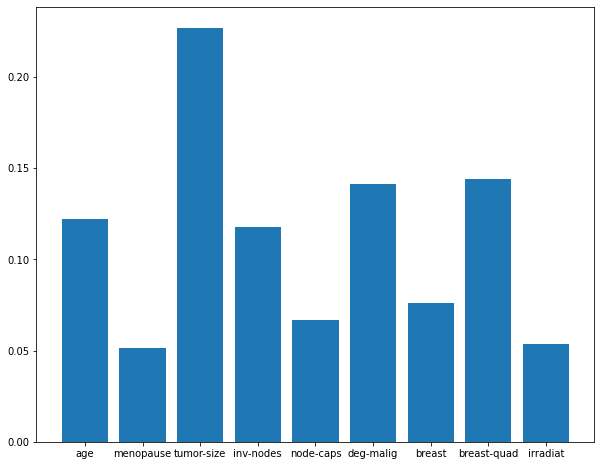

In [9]:
plt.figure(figsize=(10,8))
plt.bar(df_train.columns, model.feature_importances_)

In [34]:
# 5 K-fold on all features
from sklearn.model_selection import train_test_split

np.random.seed(123123)

kf = KFold(5, shuffle=True)
# kf.get_n_splits(df_data, y)
accs = []
f1s = []
for train_idxs, test_idxs in kf.split(df_data):
    X_train, y_train = df_data.iloc[train_idxs], y[train_idxs]
    X_test, y_test = df_data.iloc[test_idxs], y[test_idxs]
    
    model = RandomForestClassifier()

    model.fit(X_train, y_train)
    
    # Test score
    accs.append(model.score(X_test, y_test))
    f1s.append(f1_score(y_test, model.predict(X_test)))
    

In [35]:
print(f"accuracy mean acc {np.mean(accs)}, std: {np.std(accs)}")
print(f"f1 mean acc {np.mean(f1s)}, std: {np.std(f1s)}")

accuracy mean acc 0.7165154264972777, std: 0.06591084756296302
f1 mean acc 0.4089655172413793, std: 0.09818110643324982


In [36]:
# Get most important col
# n columns
col_num = 4
mvp_col = df_train.columns[sorted(range(len(model.feature_importances_)),
                                  key=lambda x: model.feature_importances_[x],
                                  reverse=True)[:col_num]].tolist()

In [37]:
# 5 K-fold on 4 mvp columns
from sklearn.model_selection import train_test_split

np.random.seed(123123)

kf = KFold(5, shuffle=True)
# kf.get_n_splits(df_data, y)
accs = []
f1s = []
for train_idxs, test_idxs in kf.split(df_data):
    X_train, y_train = df_data[mvp_col].iloc[train_idxs], y[train_idxs]
    X_test, y_test = df_data[mvp_col].iloc[test_idxs], y[test_idxs]
    
    model = RandomForestClassifier()

    model.fit(X_train, y_train)
    
    # Test score
    accs.append(model.score(X_test, y_test))
    f1s.append(f1_score(y_test, model.predict(X_test)))
    

In [38]:
print(f"accuracy mean acc {np.mean(accs)}, std: {np.std(accs)}")
print(f"f1 mean acc {np.mean(f1s)}, std: {np.std(f1s)}")

accuracy mean acc 0.6608590441621295, std: 0.046337934463956336
f1 mean acc 0.35511936339522543, std: 0.07810323895567337


# Quantum dude

In [39]:
mvp_col

['tumor-size', 'breast-quad', 'age', 'deg-malig']

In [43]:
# Get only MVP columns

df_data_q = df_data[mvp_col].values
# df_train_q = df_train[mvp_col].values
# df_test_q = df_test[mvp_col].values

In [41]:
from qiskit import IBMQ
provider = IBMQ.load_account()

IBMQAccountCredentialsNotFound: 'No IBM Quantum Experience credentials found.'

In [42]:
def double(x):
    return np.concatenate([x, x], axis=0)

# len(double(df_train_encode[y_train == 0]))

In [16]:
training_input = {
    0: df_train_q[y_train == 0],
    1: double(df_train_q[y_train == 1])
}

test_input = {
    0: df_test_q[y_test == 0],
    1: df_test_q[y_test == 1]
}

In [99]:
#  Stupid Ordinal input

# 5 K-fold on 4 mvp columns
from sklearn.model_selection import train_test_split

np.random.seed(123123)

kf = KFold(5, shuffle=True)


loss_logs = []
results = []
acc_f1s_train = []
acc_f1s_test = []


def train_ordinal_quantum(ro=0):
    seed = 10598

    vqc_ordinal_log = []
    def loss_history_callback(_, __, loss, ___):
        vqc_ordinal_log.append(loss)

    var_form = variational_forms.RYRZ(df_data_q.shape[1], depth=4)

    feature_map = ZZFeatureMap(feature_dimension=len(mvp_col), reps=3, entanglement='linear')

    qsvm = VQC(SPSA(200), feature_map, var_form, training_input, callback=loss_history_callback)

#     backend = BasicAer.get_backend('qasm_simulator')
    backend_options = {"method": "statevector_gpu"}
    backend = QasmSimulator(backend_options)
    
    quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed,optimization_level=3)


    result = qsvm.run(quantum_instance)
    
    y_pred = qsvm.predict(df_test_q)[1]
    y_pred_train = qsvm.predict(df_train_q)[1]


    # F1 score
    acc_f1_train = (np.mean(y_pred_train == y_train), f1_score(y_train, y_pred_train))
    acc_f1_test = (np.mean(y_pred == y_test), f1_score(y_test, y_pred))
    
    
    qsvm.save_model(f'models/bc_ordinal_fold_{ro}')
    
    return vqc_ordinal_log, result, acc_f1_train, acc_f1_test

for idx, (train_idxs, test_idxs) in enumerate(kf.split(df_data)):
    
    
    df_train_q, y_train = df_data_q[train_idxs], y[train_idxs]
    df_test_q, y_test = df_data_q[test_idxs], y[test_idxs]
    
    training_input = {
        0: df_train_q[y_train == 0],
        1: double(df_train_q[y_train == 1])
    }

    test_input = {
        0: df_test_q[y_test == 0],
        1: df_test_q[y_test == 1]
    }
    
    loss_log, result, acc_f1_train, acc_f1_test = train_ordinal_quantum(idx)
    loss_logs.append(loss_log)
    results.append(result)
    acc_f1s_train.append(acc_f1_train)
    acc_f1s_test.append(acc_f1_test)
    

/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: 
            The <class 'qiskit.circuit.library.data_preparation.zz_feature_map.ZZFeatureMap'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
2020-07-29 01:35:20,614:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'qasm_simulator (None)', with f

2020-07-29 01:36:53,736:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:36:55,198:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7165635262248087
2020-07-29 01:36:58,726:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:37:00,629:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7153033721557785
2020-07-29 01:37:04,631:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:37:06,056:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7161063452087709
2020-07-29 01:37:06,057:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 10 of 25
2020-07-29 01:37:09,730:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:37:11,286:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.711

2020-07-29 01:39:56,925:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7213201727712937
2020-07-29 01:39:56,926:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 0: 0.7112011
2020-07-29 01:39:56,926:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 0: 0.7213202
2020-07-29 01:40:00,797:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:40:02,223:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7256480953800102
2020-07-29 01:40:06,416:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:40:07,852:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7245152744422507
2020-07-29 01:40:07,853:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 1: 0.7256481
2020-07-29 01:40:07,854:qiskit.aqua.components.optimizers.s

2020-07-29 01:41:59,366:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7144276964519604
2020-07-29 01:42:03,221:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:42:04,700:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7098850157591973
2020-07-29 01:42:04,701:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 12: 0.7144277
2020-07-29 01:42:04,702:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 12: 0.7098850
2020-07-29 01:42:08,573:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:42:10,110:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7166912808319474
2020-07-29 01:42:13,854:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:42:15,332:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-29 01:44:00,923:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 23: 0.7257108
2020-07-29 01:44:04,765:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:44:06,259:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7269676457590559
2020-07-29 01:44:10,005:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:44:11,475:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7245999809755189
2020-07-29 01:44:11,476:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 24: 0.7269676
2020-07-29 01:44:11,476:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 24: 0.7246000
2020-07-29 01:44:15,321:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:44:16,821:qiskit.aqua.algorithms.classifi

2020-07-29 01:46:07,198:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6790670050234772
2020-07-29 01:46:07,199:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 35: 0.6833185
2020-07-29 01:46:07,199:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 35: 0.6790670
2020-07-29 01:46:10,986:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:46:12,445:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6804015397904348
2020-07-29 01:46:16,184:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:46:17,650:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6742068037451695
2020-07-29 01:46:17,650:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 36: 0.6804015
2020-07-29 01:46:17,651:qiskit.aqua.components.optimizer

2020-07-29 01:48:09,034:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6773453125643567
2020-07-29 01:48:12,769:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:48:14,231:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6797318815646587
2020-07-29 01:48:14,232:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 47: 0.6773453
2020-07-29 01:48:14,232:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 47: 0.6797319
2020-07-29 01:48:18,032:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:48:19,460:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6789763444445127
2020-07-29 01:48:23,247:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:48:24,722:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-29 01:50:10,031:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 58: 0.6799450
2020-07-29 01:50:13,794:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:50:15,251:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6910332296057843
2020-07-29 01:50:18,991:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:50:20,459:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6679232070275105
2020-07-29 01:50:20,460:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 59: 0.6910332
2020-07-29 01:50:20,461:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 59: 0.6679232
2020-07-29 01:50:24,337:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:50:25,863:qiskit.aqua.algorithms.classifi

2020-07-29 01:52:16,364:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6526299489470642
2020-07-29 01:52:16,365:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 70: 0.6721958
2020-07-29 01:52:16,365:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 70: 0.6526299
2020-07-29 01:52:20,125:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:52:21,598:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6570369903190015
2020-07-29 01:52:25,511:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:52:26,995:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6496402355263879
2020-07-29 01:52:26,996:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 71: 0.6570370
2020-07-29 01:52:26,997:qiskit.aqua.components.optimizer

2020-07-29 01:54:16,849:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.652733510157675
2020-07-29 01:54:20,599:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:54:22,039:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6510226836274026
2020-07-29 01:54:22,040:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 82: 0.6527335
2020-07-29 01:54:22,040:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 82: 0.6510227
2020-07-29 01:54:25,872:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:54:27,364:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6422012139281132
2020-07-29 01:54:31,129:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:54:32,578:qiskit.aqua.algorithms.classifiers.vqc:DEB

2020-07-29 01:56:18,051:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 93: 0.6552349
2020-07-29 01:56:21,834:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:56:23,283:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6477894626125906
2020-07-29 01:56:26,973:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:56:28,426:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6556360817115144
2020-07-29 01:56:28,427:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 94: 0.6477895
2020-07-29 01:56:28,427:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 94: 0.6556361
2020-07-29 01:56:32,107:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:56:33,554:qiskit.aqua.algorithms.classifi

2020-07-29 01:58:24,139:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6458349766665191
2020-07-29 01:58:24,140:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 105: 0.6402637
2020-07-29 01:58:24,140:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 105: 0.6458350
2020-07-29 01:58:27,959:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:58:29,517:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6466447365317641
2020-07-29 01:58:33,242:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 01:58:34,703:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.644440136233816
2020-07-29 01:58:34,704:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 106: 0.6466447
2020-07-29 01:58:34,704:qiskit.aqua.components.optimiz

2020-07-29 02:00:25,423:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6345386733418897
2020-07-29 02:00:29,285:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:00:30,761:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6396811353508896
2020-07-29 02:00:30,762:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 117: 0.6345387
2020-07-29 02:00:30,762:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 117: 0.6396811
2020-07-29 02:00:34,465:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:00:35,913:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6389138071601819
2020-07-29 02:00:39,793:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:00:41,289:qiskit.aqua.algorithms.classifiers.vqc:

2020-07-29 02:02:26,841:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 128: 0.6318880
2020-07-29 02:02:30,631:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:02:32,070:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6309369199644074
2020-07-29 02:02:35,880:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:02:37,351:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6393752437141357
2020-07-29 02:02:37,352:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 129: 0.6309369
2020-07-29 02:02:37,352:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 129: 0.6393752
2020-07-29 02:02:41,104:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:02:42,577:qiskit.aqua.algorithms.class

2020-07-29 02:04:33,367:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6310526118865838
2020-07-29 02:04:33,367:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 140: 0.6315781
2020-07-29 02:04:33,368:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 140: 0.6310526
2020-07-29 02:04:37,114:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:04:38,526:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6299317885442147
2020-07-29 02:04:42,249:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:04:43,760:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6337685259956496
2020-07-29 02:04:43,761:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 141: 0.6299318
2020-07-29 02:04:43,762:qiskit.aqua.components.optimi

2020-07-29 02:06:34,672:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6252131705941959
2020-07-29 02:06:38,357:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:06:39,811:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6332900647830053
2020-07-29 02:06:39,812:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 152: 0.6252132
2020-07-29 02:06:39,812:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 152: 0.6332901
2020-07-29 02:06:43,597:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:06:45,046:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6243860047625852
2020-07-29 02:06:48,832:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:06:50,318:qiskit.aqua.algorithms.classifiers.vqc:

2020-07-29 02:08:35,768:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 163: 0.6263741
2020-07-29 02:08:39,604:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:08:41,050:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6249313197679194
2020-07-29 02:08:44,858:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:08:46,310:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6293733613059952
2020-07-29 02:08:46,311:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 164: 0.6249313
2020-07-29 02:08:46,311:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 164: 0.6293734
2020-07-29 02:08:50,104:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:08:51,595:qiskit.aqua.algorithms.class

2020-07-29 02:10:42,450:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6253222410610787
2020-07-29 02:10:42,451:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 175: 0.6235460
2020-07-29 02:10:42,452:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 175: 0.6253222
2020-07-29 02:10:46,160:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:10:47,631:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6253961911428426
2020-07-29 02:10:51,302:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:10:52,782:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6263436197767834
2020-07-29 02:10:52,783:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 176: 0.6253962
2020-07-29 02:10:52,784:qiskit.aqua.components.optimi

2020-07-29 02:12:44,502:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6189524334251504
2020-07-29 02:12:48,294:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:12:49,787:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6257483350707801
2020-07-29 02:12:49,788:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 187: 0.6189524
2020-07-29 02:12:49,788:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 187: 0.6257483
2020-07-29 02:12:53,667:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:12:55,114:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6174662281562079
2020-07-29 02:12:58,891:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:13:00,373:qiskit.aqua.algorithms.classifiers.vqc:

2020-07-29 02:14:45,982:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 198: 0.6163658
2020-07-29 02:14:49,709:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:14:51,170:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6169011533012779
2020-07-29 02:14:54,885:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:14:56,343:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6178066394712796
2020-07-29 02:14:56,344:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 199: 0.6169012
2020-07-29 02:14:56,345:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 199: 0.6178066
2020-07-29 02:15:00,234:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:15:01,678:qiskit.aqua.algorithms.class

2020-07-29 02:16:09,716:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7408729525140582
2020-07-29 02:16:13,562:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:16:15,017:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7308338598320556
2020-07-29 02:16:18,740:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:16:20,237:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7569248080297948
2020-07-29 02:16:23,369:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:16:25,292:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7427043419271537
2020-07-29 02:16:29,171:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:16:30,572:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate b

2020-07-29 02:19:12,079:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7413556389103709
2020-07-29 02:19:16,304:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:19:17,704:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7448322212442386
2020-07-29 02:19:21,273:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:19:22,698:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.744639655052004
2020-07-29 02:19:26,300:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:19:28,220:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7460542688709115
2020-07-29 02:19:28,221:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibrated SPSA parameter c0 is 6.5218204
2020-07-29 02:19:31,572:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation 

2020-07-29 02:21:22,933:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.685865264451479
2020-07-29 02:21:22,934:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 10: 0.7087857
2020-07-29 02:21:22,934:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 10: 0.6858653
2020-07-29 02:21:26,644:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:21:28,146:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6920041274340301
2020-07-29 02:21:31,859:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:21:33,295:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.693111610793787
2020-07-29 02:21:33,296:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 11: 0.6920041
2020-07-29 02:21:33,297:qiskit.aqua.components.optimizers.

2020-07-29 02:23:23,045:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6787106724489219
2020-07-29 02:23:26,773:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:23:28,222:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6870903886353348
2020-07-29 02:23:28,223:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 22: 0.6787107
2020-07-29 02:23:28,224:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 22: 0.6870904
2020-07-29 02:23:31,947:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:23:33,394:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6819533300203571
2020-07-29 02:23:37,151:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:23:38,625:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-29 02:25:23,077:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 33: 0.6778213
2020-07-29 02:25:26,858:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:25:28,387:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.667093453955515
2020-07-29 02:25:32,073:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:25:33,575:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6797371944353398
2020-07-29 02:25:33,576:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 34: 0.6670935
2020-07-29 02:25:33,577:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 34: 0.6797372
2020-07-29 02:25:36,838:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:25:38,830:qiskit.aqua.algorithms.classifie

2020-07-29 02:27:29,593:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6607485499076207
2020-07-29 02:27:29,594:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 45: 0.6683814
2020-07-29 02:27:29,595:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 45: 0.6607485
2020-07-29 02:27:33,135:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:27:35,105:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6654739267253189
2020-07-29 02:27:38,492:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:27:39,950:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6612076104893548
2020-07-29 02:27:39,951:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 46: 0.6654739
2020-07-29 02:27:39,951:qiskit.aqua.components.optimizer

2020-07-29 02:29:30,468:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6592503621112832
2020-07-29 02:29:33,640:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:29:35,517:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6556233615128405
2020-07-29 02:29:35,518:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 57: 0.6592504
2020-07-29 02:29:35,518:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 57: 0.6556234
2020-07-29 02:29:38,975:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:29:40,409:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6599553676654891
2020-07-29 02:29:44,753:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:29:46,145:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-29 02:31:30,895:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 68: 0.6521770
2020-07-29 02:31:34,754:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:31:36,250:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6493990223131335
2020-07-29 02:31:40,098:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:31:41,541:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6507560095803744
2020-07-29 02:31:41,542:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 69: 0.6493990
2020-07-29 02:31:41,543:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 69: 0.6507560
2020-07-29 02:31:45,300:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:31:46,761:qiskit.aqua.algorithms.classifi

2020-07-29 02:33:36,433:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6542916612099284
2020-07-29 02:33:36,434:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 80: 0.6421483
2020-07-29 02:33:36,435:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 80: 0.6542917
2020-07-29 02:33:39,767:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:33:41,207:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6472175310498538
2020-07-29 02:33:44,929:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:33:46,357:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6428264172427732
2020-07-29 02:33:46,358:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 81: 0.6472175
2020-07-29 02:33:46,359:qiskit.aqua.components.optimizer

2020-07-29 02:35:36,326:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6364077979121456
2020-07-29 02:35:39,708:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:35:41,201:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6320647937582953
2020-07-29 02:35:41,202:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 92: 0.6364078
2020-07-29 02:35:41,203:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 92: 0.6320648
2020-07-29 02:35:44,975:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:35:46,416:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6343124678244766
2020-07-29 02:35:50,146:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:35:51,587:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-29 02:37:36,349:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 103: 0.6293804
2020-07-29 02:37:39,654:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:37:41,537:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6285274996214549
2020-07-29 02:37:44,808:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:37:46,251:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6279195914929389
2020-07-29 02:37:46,252:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 104: 0.6285275
2020-07-29 02:37:46,253:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 104: 0.6279196
2020-07-29 02:37:49,922:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:37:51,862:qiskit.aqua.algorithms.class

2020-07-29 02:39:41,921:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6340704346748526
2020-07-29 02:39:41,922:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 115: 0.6241359
2020-07-29 02:39:41,923:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 115: 0.6340704
2020-07-29 02:39:45,618:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:39:47,093:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.626293632961256
2020-07-29 02:39:50,819:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:39:52,258:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.626003232392147
2020-07-29 02:39:52,259:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 116: 0.6262936
2020-07-29 02:39:52,260:qiskit.aqua.components.optimize

2020-07-29 02:41:41,377:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6259646105779555
2020-07-29 02:41:45,060:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:41:46,541:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6271042198817739
2020-07-29 02:41:46,542:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 127: 0.6259646
2020-07-29 02:41:46,542:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 127: 0.6271042
2020-07-29 02:41:50,207:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:41:51,690:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6274949508457153
2020-07-29 02:41:55,504:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:41:56,957:qiskit.aqua.algorithms.classifiers.vqc:

2020-07-29 02:43:41,283:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 138: 0.6230608
2020-07-29 02:43:45,544:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:43:46,955:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6251290825862696
2020-07-29 02:43:50,461:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:43:51,889:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6240774028234333
2020-07-29 02:43:51,890:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 139: 0.6251291
2020-07-29 02:43:51,891:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 139: 0.6240774
2020-07-29 02:43:55,447:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:43:57,355:qiskit.aqua.algorithms.class

2020-07-29 02:45:47,785:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6208376967337466
2020-07-29 02:45:47,786:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 150: 0.6251025
2020-07-29 02:45:47,787:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 150: 0.6208377
2020-07-29 02:45:51,503:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:45:52,932:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6213590708335726
2020-07-29 02:45:56,220:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:45:58,224:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6214705457318087
2020-07-29 02:45:58,225:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 151: 0.6213591
2020-07-29 02:45:58,225:qiskit.aqua.components.optimi

2020-07-29 02:47:48,964:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6238869421702505
2020-07-29 02:47:52,403:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:47:53,850:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6240748575644848
2020-07-29 02:47:53,851:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 162: 0.6238869
2020-07-29 02:47:53,851:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 162: 0.6240749
2020-07-29 02:47:57,659:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:47:59,097:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6240804376864029
2020-07-29 02:48:02,973:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:48:04,396:qiskit.aqua.algorithms.classifiers.vqc:

2020-07-29 02:49:50,376:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 173: 0.6236466
2020-07-29 02:49:53,928:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:49:55,356:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6215635032584361
2020-07-29 02:49:58,927:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:50:00,954:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.623465941245336
2020-07-29 02:50:00,955:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 174: 0.6215635
2020-07-29 02:50:00,956:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 174: 0.6234659
2020-07-29 02:50:04,380:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:50:05,882:qiskit.aqua.algorithms.classi

2020-07-29 02:51:55,982:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6228492701301614
2020-07-29 02:51:55,983:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 185: 0.6243047
2020-07-29 02:51:55,983:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 185: 0.6228493
2020-07-29 02:51:59,642:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:52:01,120:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6224084798064228
2020-07-29 02:52:04,760:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:52:06,627:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6217255050281557
2020-07-29 02:52:06,628:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 186: 0.6224085
2020-07-29 02:52:06,628:qiskit.aqua.components.optimi

2020-07-29 02:53:56,563:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6234831210734587
2020-07-29 02:54:00,203:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:54:01,627:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6199419644997398
2020-07-29 02:54:01,628:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 197: 0.6234831
2020-07-29 02:54:01,628:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 197: 0.6199420
2020-07-29 02:54:05,759:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:54:07,172:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6234233388949416
2020-07-29 02:54:10,690:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:54:12,591:qiskit.aqua.algorithms.classifiers.vqc:

2020-07-29 02:55:08,474:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:55:10,395:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7391593828431757
2020-07-29 02:55:13,976:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:55:15,418:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7136689713030249
2020-07-29 02:55:19,219:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:55:20,727:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7313985093408462
2020-07-29 02:55:24,536:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:55:25,962:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7316426502711296
2020-07-29 02:55:25,963:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration st

2020-07-29 02:58:08,849:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7183394356587507
2020-07-29 02:58:12,620:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:58:14,058:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7340127518709818
2020-07-29 02:58:17,822:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:58:19,323:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7351515874991602
2020-07-29 02:58:23,045:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:58:24,497:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.731282263286719
2020-07-29 02:58:28,208:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 02:58:29,649:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate ba

2020-07-29 03:00:31,005:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7008318188308409
2020-07-29 03:00:31,006:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 8: 0.7137048
2020-07-29 03:00:31,006:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 8: 0.7008318
2020-07-29 03:00:34,846:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:00:36,348:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.701127043099902
2020-07-29 03:00:40,147:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:00:41,604:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7085839477301096
2020-07-29 03:00:41,605:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 9: 0.7011270
2020-07-29 03:00:41,606:qiskit.aqua.components.optimizers.sp

2020-07-29 03:02:32,700:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6755834344933384
2020-07-29 03:02:36,417:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:02:37,862:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6753648379281484
2020-07-29 03:02:37,863:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 20: 0.6755834
2020-07-29 03:02:37,863:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 20: 0.6753648
2020-07-29 03:02:41,692:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:02:43,126:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6762666102946198
2020-07-29 03:02:46,901:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:02:48,473:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-29 03:04:33,898:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 31: 0.6899678
2020-07-29 03:04:37,612:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:04:39,058:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6935782918484779
2020-07-29 03:04:42,802:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:04:44,252:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6867729176344243
2020-07-29 03:04:44,252:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 32: 0.6935783
2020-07-29 03:04:44,253:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 32: 0.6867729
2020-07-29 03:04:48,093:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:04:49,562:qiskit.aqua.algorithms.classifi

2020-07-29 03:06:40,168:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6688537417721286
2020-07-29 03:06:40,169:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 43: 0.6685894
2020-07-29 03:06:40,169:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 43: 0.6688537
2020-07-29 03:06:43,866:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:06:45,365:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6662064084425632
2020-07-29 03:06:49,101:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:06:50,552:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.677589376267155
2020-07-29 03:06:50,553:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 44: 0.6662064
2020-07-29 03:06:50,554:qiskit.aqua.components.optimizers

2020-07-29 03:08:40,298:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6599484103020086
2020-07-29 03:08:44,010:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:08:45,465:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6554445458775626
2020-07-29 03:08:45,466:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 55: 0.6599484
2020-07-29 03:08:45,466:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 55: 0.6554445
2020-07-29 03:08:49,361:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:08:50,859:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6563024037337671
2020-07-29 03:08:54,647:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:08:56,092:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-29 03:10:40,895:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 66: 0.6519371
2020-07-29 03:10:44,622:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:10:46,070:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6506595546671967
2020-07-29 03:10:49,953:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:10:51,438:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6533617767579251
2020-07-29 03:10:51,439:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 67: 0.6506596
2020-07-29 03:10:51,440:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 67: 0.6533618
2020-07-29 03:10:55,233:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:10:56,718:qiskit.aqua.algorithms.classifi

2020-07-29 03:12:47,022:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6513467478914713
2020-07-29 03:12:47,023:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 78: 0.6439531
2020-07-29 03:12:47,024:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 78: 0.6513467
2020-07-29 03:12:50,751:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:12:52,194:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6484536992684119
2020-07-29 03:12:56,084:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:12:57,641:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6465660596321435
2020-07-29 03:12:57,642:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 79: 0.6484537
2020-07-29 03:12:57,642:qiskit.aqua.components.optimizer

2020-07-29 03:14:48,019:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6385511370252105
2020-07-29 03:14:51,736:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:14:53,185:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6483351223826324
2020-07-29 03:14:53,186:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 90: 0.6385511
2020-07-29 03:14:53,187:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 90: 0.6483351
2020-07-29 03:14:57,154:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:14:58,619:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6406750017372008
2020-07-29 03:15:02,408:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:15:03,891:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-29 03:16:48,938:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 101: 0.6363614
2020-07-29 03:16:52,576:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:16:54,071:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6404439282481145
2020-07-29 03:16:57,808:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:16:59,301:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6339077076362997
2020-07-29 03:16:59,302:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 102: 0.6404439
2020-07-29 03:16:59,303:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 102: 0.6339077
2020-07-29 03:17:03,096:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:17:04,554:qiskit.aqua.algorithms.class

2020-07-29 03:18:55,237:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6339632182933707
2020-07-29 03:18:55,238:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 113: 0.6350092
2020-07-29 03:18:55,239:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 113: 0.6339632
2020-07-29 03:18:58,975:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:19:00,462:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6345307909894888
2020-07-29 03:19:04,233:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:19:05,673:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6325486488345257
2020-07-29 03:19:05,674:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 114: 0.6345308
2020-07-29 03:19:05,675:qiskit.aqua.components.optimi

2020-07-29 03:20:56,449:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6305911255731577
2020-07-29 03:21:00,228:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:21:01,673:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6327250881716823
2020-07-29 03:21:01,674:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 125: 0.6305911
2020-07-29 03:21:01,675:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 125: 0.6327251
2020-07-29 03:21:05,469:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:21:06,985:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.631280224566874
2020-07-29 03:21:10,751:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:21:12,194:qiskit.aqua.algorithms.classifiers.vqc:D

2020-07-29 03:22:57,496:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 136: 0.6326706
2020-07-29 03:23:01,189:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:23:02,662:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6238249708927733
2020-07-29 03:23:06,403:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:23:07,845:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6280167994056493
2020-07-29 03:23:07,846:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 137: 0.6238250
2020-07-29 03:23:07,846:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 137: 0.6280168
2020-07-29 03:23:11,553:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:23:13,047:qiskit.aqua.algorithms.class

2020-07-29 03:25:03,031:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6220575536138501
2020-07-29 03:25:03,032:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 148: 0.6247416
2020-07-29 03:25:03,033:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 148: 0.6220576
2020-07-29 03:25:06,839:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:25:08,294:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.627651128892087
2020-07-29 03:25:12,131:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:25:13,626:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6216122047013893
2020-07-29 03:25:13,627:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 149: 0.6276511
2020-07-29 03:25:13,628:qiskit.aqua.components.optimiz

2020-07-29 03:27:03,742:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6230888990545397
2020-07-29 03:27:07,467:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:27:08,915:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.61989795060046
2020-07-29 03:27:08,916:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 160: 0.6230889
2020-07-29 03:27:08,917:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 160: 0.6198980
2020-07-29 03:27:12,709:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:27:14,189:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6231543208678108
2020-07-29 03:27:17,845:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:27:19,289:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-29 03:29:04,391:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 171: 0.6224216
2020-07-29 03:29:08,226:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:29:09,682:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6204125682709801
2020-07-29 03:29:13,393:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:29:14,886:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6188002976422693
2020-07-29 03:29:14,887:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 172: 0.6204126
2020-07-29 03:29:14,887:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 172: 0.6188003
2020-07-29 03:29:18,667:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:29:20,070:qiskit.aqua.algorithms.class

2020-07-29 03:31:10,087:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6201743321735653
2020-07-29 03:31:10,088:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 183: 0.6207118
2020-07-29 03:31:10,088:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 183: 0.6201743
2020-07-29 03:31:13,877:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:31:15,322:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6212298824291875
2020-07-29 03:31:19,020:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:31:20,467:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6186951330876794
2020-07-29 03:31:20,468:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 184: 0.6212299
2020-07-29 03:31:20,469:qiskit.aqua.components.optimi

2020-07-29 03:33:11,249:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6201625643401487
2020-07-29 03:33:15,017:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:33:16,492:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6166125673710621
2020-07-29 03:33:16,493:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 195: 0.6201626
2020-07-29 03:33:16,494:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 195: 0.6166126
2020-07-29 03:33:20,185:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:33:21,642:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6208789000067491
2020-07-29 03:33:25,375:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:33:26,819:qiskit.aqua.algorithms.classifiers.vqc:

2020-07-29 03:34:15,353:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7021017236958584
2020-07-29 03:34:19,006:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:34:20,429:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7011718277370573
2020-07-29 03:34:24,143:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:34:25,562:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7155603914056827
2020-07-29 03:34:29,272:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:34:30,698:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.701418427508145
2020-07-29 03:34:34,440:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:34:35,866:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate ba

2020-07-29 03:37:18,639:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7023600978926304
2020-07-29 03:37:22,417:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:37:23,860:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7123624837393382
2020-07-29 03:37:27,584:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:37:29,043:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7129333557899468
2020-07-29 03:37:32,341:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:37:34,382:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6991596910106914
2020-07-29 03:37:37,673:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:37:39,120:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate b

2020-07-29 03:39:44,630:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 6: 0.7440082
2020-07-29 03:39:44,631:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 6: 0.7484102
2020-07-29 03:39:48,537:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:39:49,995:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7400422142508051
2020-07-29 03:39:53,791:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:39:55,264:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.740721342458042
2020-07-29 03:39:55,265:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 7: 0.7400422
2020-07-29 03:39:55,265:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 7: 0.7407213
2020-07-29 03:39:59,032:qiskit.aqua.utils.run_circu

2020-07-29 03:41:48,242:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:41:49,674:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.707887569415658
2020-07-29 03:41:49,675:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 18: 0.7106969
2020-07-29 03:41:49,675:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 18: 0.7078876
2020-07-29 03:41:53,795:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:41:55,192:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7127912134596022
2020-07-29 03:41:59,292:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:42:00,689:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7023369884696609
2020-07-29 03:42:00,690:qiskit.aqua.components.optimizers.spsa:DEB

2020-07-29 03:43:48,320:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:43:49,772:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6817364301251007
2020-07-29 03:43:53,321:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:43:55,210:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6924540126666356
2020-07-29 03:43:55,211:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 30: 0.6817364
2020-07-29 03:43:55,212:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 30: 0.6924540
2020-07-29 03:43:58,626:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:44:00,096:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6787520223971415
2020-07-29 03:44:03,986:qiskit.aqua.utils.run_circuits:INFO: Can'

2020-07-29 03:45:49,906:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 41: 0.6872260
2020-07-29 03:45:49,907:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 41: 0.6699418
2020-07-29 03:45:53,785:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:45:55,281:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6694571632535514
2020-07-29 03:45:59,066:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:46:00,546:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6933844216721704
2020-07-29 03:46:00,547:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 42: 0.6694572
2020-07-29 03:46:00,548:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 42: 0.6933844
2020-07-29 03:46:04,356:qiskit.aqua.utils.run_

2020-07-29 03:47:51,926:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:47:53,374:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6696404518079397
2020-07-29 03:47:53,375:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 53: 0.6740292
2020-07-29 03:47:53,376:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 53: 0.6696405
2020-07-29 03:47:57,147:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:47:58,617:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6724605302519094
2020-07-29 03:48:02,310:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:48:03,784:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6708666866161327
2020-07-29 03:48:03,785:qiskit.aqua.components.optimizers.spsa:DE

2020-07-29 03:49:51,368:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:49:52,869:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6483373504115467
2020-07-29 03:49:56,126:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:49:58,009:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6588184998994908
2020-07-29 03:49:58,010:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 65: 0.6483374
2020-07-29 03:49:58,010:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 65: 0.6588185
2020-07-29 03:50:01,369:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:50:02,805:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6562898637432645
2020-07-29 03:50:06,482:qiskit.aqua.utils.run_circuits:INFO: Can'

2020-07-29 03:51:51,156:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 76: 0.6499203
2020-07-29 03:51:51,157:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 76: 0.6429765
2020-07-29 03:51:55,006:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:51:56,517:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6431998614810723
2020-07-29 03:51:59,730:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:52:01,610:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6457722871905262
2020-07-29 03:52:01,611:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 77: 0.6431999
2020-07-29 03:52:01,612:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 77: 0.6457723
2020-07-29 03:52:04,951:qiskit.aqua.utils.run_

2020-07-29 03:53:54,613:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:53:56,037:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.64345582203879
2020-07-29 03:53:56,038:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 88: 0.6443993
2020-07-29 03:53:56,039:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 88: 0.6434558
2020-07-29 03:53:59,931:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:54:01,465:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6479231177265061
2020-07-29 03:54:05,209:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:54:06,689:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.639564763299097
2020-07-29 03:54:06,690:qiskit.aqua.components.optimizers.spsa:DEBUG

2020-07-29 03:55:53,218:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:55:54,673:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6378258221125704
2020-07-29 03:55:58,417:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:55:59,908:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6398888755649906
2020-07-29 03:55:59,909:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 100: 0.6378258
2020-07-29 03:55:59,910:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 100: 0.6398889
2020-07-29 03:56:03,650:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:56:05,096:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6377616508641801
2020-07-29 03:56:08,802:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-07-29 03:57:53,728:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 111: 0.6398866
2020-07-29 03:57:53,728:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 111: 0.6384403
2020-07-29 03:57:57,494:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:57:58,947:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6386831038320315
2020-07-29 03:58:02,458:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:58:04,332:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6364883551592074
2020-07-29 03:58:04,333:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 112: 0.6386831
2020-07-29 03:58:04,334:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 112: 0.6364884
2020-07-29 03:58:07,645:qiskit.aqua.utils.

2020-07-29 03:59:56,377:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 03:59:57,876:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6391064153209519
2020-07-29 03:59:57,877:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 123: 0.6357712
2020-07-29 03:59:57,877:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 123: 0.6391064
2020-07-29 04:00:01,548:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:00:03,030:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6340558353794451
2020-07-29 04:00:06,337:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:00:08,203:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6373891786296599
2020-07-29 04:00:08,204:qiskit.aqua.components.optimizers.spsa:

2020-07-29 04:01:54,764:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:01:56,273:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6393140609096839
2020-07-29 04:01:59,981:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:02:01,409:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.632429511582022
2020-07-29 04:02:01,410:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 135: 0.6393141
2020-07-29 04:02:01,411:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 135: 0.6324295
2020-07-29 04:02:05,261:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:02:06,701:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6342773975264266
2020-07-29 04:02:10,496:qiskit.aqua.utils.run_circuits:INFO: Can

2020-07-29 04:03:55,575:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 146: 0.6305074
2020-07-29 04:03:55,575:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 146: 0.6309748
2020-07-29 04:03:59,895:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:04:01,352:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6328762342998341
2020-07-29 04:04:04,892:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:04:06,303:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6317197529140086
2020-07-29 04:04:06,304:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 147: 0.6328762
2020-07-29 04:04:06,304:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 147: 0.6317198
2020-07-29 04:04:09,700:qiskit.aqua.utils.

2020-07-29 04:05:58,442:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:05:59,879:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6262564139854959
2020-07-29 04:05:59,880:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 158: 0.6309260
2020-07-29 04:05:59,880:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 158: 0.6262564
2020-07-29 04:06:03,634:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:06:05,081:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6294189250170036
2020-07-29 04:06:08,945:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:06:10,409:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6302975753027205
2020-07-29 04:06:10,410:qiskit.aqua.components.optimizers.spsa:

2020-07-29 04:07:58,414:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:07:59,853:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6292268741459994
2020-07-29 04:08:03,461:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:08:04,926:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6316009883142673
2020-07-29 04:08:04,927:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 170: 0.6292269
2020-07-29 04:08:04,928:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 170: 0.6316010
2020-07-29 04:08:08,525:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:08:10,473:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6320115646950977
2020-07-29 04:08:13,838:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-07-29 04:09:58,735:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 181: 0.6270083
2020-07-29 04:09:58,735:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 181: 0.6335224
2020-07-29 04:10:02,500:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:10:03,933:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6309200625851813
2020-07-29 04:10:07,836:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:10:09,348:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6257236839345353
2020-07-29 04:10:09,349:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 182: 0.6309201
2020-07-29 04:10:09,350:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 182: 0.6257237
2020-07-29 04:10:13,169:qiskit.aqua.utils.

2020-07-29 04:12:03,186:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:12:05,046:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6292552315585461
2020-07-29 04:12:05,047:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 193: 0.6220522
2020-07-29 04:12:05,048:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 193: 0.6292552
2020-07-29 04:12:08,455:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:12:09,883:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6264766955483008
2020-07-29 04:12:13,656:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:12:15,133:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6245737934168741
2020-07-29 04:12:15,133:qiskit.aqua.components.optimizers.spsa:

2020-07-29 04:13:16,459:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: SPSA does not support bounds. It will be ignored.
2020-07-29 04:13:16,460:qiskit.aqua.components.optimizers.spsa:DEBUG: Parameters: [0.62831853 0.1        0.602      0.101      0.        ]
2020-07-29 04:13:16,461:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibration...
2020-07-29 04:13:16,462:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 0 of 25
2020-07-29 04:13:20,170:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:13:21,581:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7727210618855713
2020-07-29 04:13:25,220:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:13:27,314:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7352486201860681
2020-07-29 04:13:30,628:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation

2020-07-29 04:16:12,123:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:16:13,543:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.766305941005301
2020-07-29 04:16:17,110:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:16:18,981:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.755836882218656
2020-07-29 04:16:22,299:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:16:23,723:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7474711472248575
2020-07-29 04:16:27,376:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:16:28,804:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7438917694329654
2020-07-29 04:16:32,469:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validatio

2020-07-29 04:18:36,982:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5: 0.7165971
2020-07-29 04:18:40,768:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:18:42,221:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7032941925222965
2020-07-29 04:18:46,093:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:18:47,558:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7138925273717766
2020-07-29 04:18:47,559:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 6: 0.7032942
2020-07-29 04:18:47,559:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 6: 0.7138925
2020-07-29 04:18:51,324:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:18:52,724:qiskit.aqua.algorithms.classifiers

2020-07-29 04:20:43,234:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7081198558968863
2020-07-29 04:20:43,235:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 17: 0.6999054
2020-07-29 04:20:43,235:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 17: 0.7081199
2020-07-29 04:20:46,448:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:20:47,868:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7148149983806442
2020-07-29 04:20:51,477:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:20:53,340:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6912333559058772
2020-07-29 04:20:53,341:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 18: 0.7148150
2020-07-29 04:20:53,342:qiskit.aqua.components.optimizer

2020-07-29 04:22:44,132:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6660729135807659
2020-07-29 04:22:48,356:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:22:49,745:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6686103341737683
2020-07-29 04:22:49,746:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 29: 0.6660729
2020-07-29 04:22:49,747:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 29: 0.6686103
2020-07-29 04:22:53,763:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:22:55,155:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6717217070553253
2020-07-29 04:22:58,771:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:23:00,205:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-29 04:24:44,306:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 40: 0.6618659
2020-07-29 04:24:48,058:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:24:49,527:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6645188964843575
2020-07-29 04:24:52,689:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:24:54,553:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6639092789851627
2020-07-29 04:24:54,554:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 41: 0.6645189
2020-07-29 04:24:54,554:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 41: 0.6639093
2020-07-29 04:24:58,363:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:24:59,889:qiskit.aqua.algorithms.classifi

2020-07-29 04:26:49,018:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6507644933789423
2020-07-29 04:26:49,019:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 52: 0.6519548
2020-07-29 04:26:49,020:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 52: 0.6507645
2020-07-29 04:26:52,853:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:26:54,305:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6584707592375031
2020-07-29 04:26:58,517:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:26:59,953:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.655464498348973
2020-07-29 04:26:59,954:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 53: 0.6584708
2020-07-29 04:26:59,955:qiskit.aqua.components.optimizers

2020-07-29 04:28:49,424:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6572262772730454
2020-07-29 04:28:53,231:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:28:54,697:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6468777795886369
2020-07-29 04:28:54,698:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 64: 0.6572263
2020-07-29 04:28:54,698:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 64: 0.6468778
2020-07-29 04:28:58,037:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:29:00,020:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6508941334422115
2020-07-29 04:29:03,408:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:29:04,827:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-29 04:30:50,069:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 75: 0.6427191
2020-07-29 04:30:54,394:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:30:55,822:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6494165027810977
2020-07-29 04:30:59,477:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:31:00,897:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6443764430726884
2020-07-29 04:31:00,898:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 76: 0.6494165
2020-07-29 04:31:00,899:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 76: 0.6443764
2020-07-29 04:31:04,446:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:31:05,875:qiskit.aqua.algorithms.classifi

2020-07-29 04:32:54,424:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6379976100946932
2020-07-29 04:32:54,425:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 87: 0.6414722
2020-07-29 04:32:54,426:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 87: 0.6379976
2020-07-29 04:32:57,685:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:32:59,144:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.634838878214737
2020-07-29 04:33:02,884:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:33:04,297:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.64386000374155
2020-07-29 04:33:04,298:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 88: 0.6348389
2020-07-29 04:33:04,298:qiskit.aqua.components.optimizers.s

2020-07-29 04:34:52,699:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6371314723203456
2020-07-29 04:34:56,580:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:34:58,009:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6344608912017882
2020-07-29 04:34:58,010:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 99: 0.6371315
2020-07-29 04:34:58,010:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 99: 0.6344609
2020-07-29 04:35:02,004:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:35:03,485:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6351925843385535
2020-07-29 04:35:06,765:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:35:08,659:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-29 04:36:52,889:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 110: 0.6299179
2020-07-29 04:36:57,175:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:36:58,640:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6360446987033618
2020-07-29 04:37:02,651:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:37:04,071:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6336113257246893
2020-07-29 04:37:04,072:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 111: 0.6360447
2020-07-29 04:37:04,073:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 111: 0.6336113
2020-07-29 04:37:07,593:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:37:09,004:qiskit.aqua.algorithms.class

2020-07-29 04:38:57,193:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6257070134509939
2020-07-29 04:38:57,194:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 122: 0.6274648
2020-07-29 04:38:57,195:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 122: 0.6257070
2020-07-29 04:39:00,869:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:39:02,313:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6292251524290084
2020-07-29 04:39:06,049:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:39:07,577:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6286357467529144
2020-07-29 04:39:07,578:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 123: 0.6292252
2020-07-29 04:39:07,578:qiskit.aqua.components.optimi

2020-07-29 04:40:57,890:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6291580947466879
2020-07-29 04:41:01,580:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:41:03,539:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.624191540111104
2020-07-29 04:41:03,540:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 134: 0.6291581
2020-07-29 04:41:03,541:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 134: 0.6241915
2020-07-29 04:41:07,002:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:41:08,523:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6254378779480033
2020-07-29 04:41:12,225:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:41:13,692:qiskit.aqua.algorithms.classifiers.vqc:D

2020-07-29 04:42:57,193:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 145: 0.6247318
2020-07-29 04:43:01,435:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:43:02,934:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.625803990618395
2020-07-29 04:43:06,828:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:43:08,238:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6214083600581923
2020-07-29 04:43:08,239:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 146: 0.6258040
2020-07-29 04:43:08,239:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 146: 0.6214084
2020-07-29 04:43:11,788:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:43:13,236:qiskit.aqua.algorithms.classi

2020-07-29 04:45:01,832:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6248956965519854
2020-07-29 04:45:01,833:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 157: 0.6229231
2020-07-29 04:45:01,834:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 157: 0.6248957
2020-07-29 04:45:05,170:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:45:06,613:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6247301535501842
2020-07-29 04:45:10,760:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:45:12,264:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6229916579669362
2020-07-29 04:45:12,265:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 158: 0.6247302
2020-07-29 04:45:12,265:qiskit.aqua.components.optimi

2020-07-29 04:47:02,590:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6198476816400346
2020-07-29 04:47:06,219:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:47:07,660:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6231388641402321
2020-07-29 04:47:07,661:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 169: 0.6198477
2020-07-29 04:47:07,662:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 169: 0.6231389
2020-07-29 04:47:10,783:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:47:12,690:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6219112157891068
2020-07-29 04:47:16,038:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:47:17,462:qiskit.aqua.algorithms.classifiers.vqc:

2020-07-29 04:50:56,420:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6193618774559814
2020-07-29 04:50:56,421:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 191: 0.6197265
2020-07-29 04:50:56,422:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 191: 0.6193619
2020-07-29 04:51:00,243:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:51:01,639:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6218279182888893
2020-07-29 04:51:05,377:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:51:06,776:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6199408939068961
2020-07-29 04:51:06,777:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 192: 0.6218279
2020-07-29 04:51:06,778:qiskit.aqua.components.optimi

In [69]:
acc_f1s

[(0.5, 0.35555555555555557),
 (0.5263157894736842, 0.27027027027027023),
 (0.6140350877192983, 0.26666666666666666),
 (0.5614035087719298, 0.4186046511627907),
 (0.5964912280701754, 0.5106382978723405)]

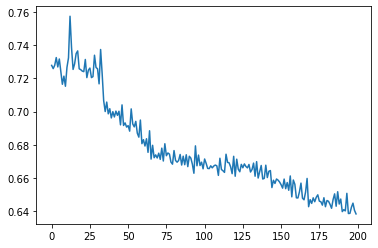

In [74]:
plt.plot(loss_logs[4][-200:])

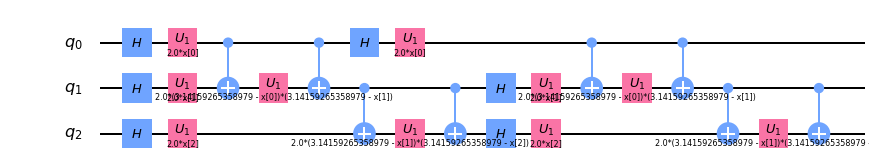

In [78]:
ZZFeatureMap(feature_dimension=len(mvp_col), reps=2, entanglement='linear').draw('mpl')

In [37]:
y_pred = qsvm.predict(df_test_q)[1]


# F1 score
np.mean(y_pred == y_test), f1_score(y_test, y_pred)

2020-07-08 02:30:46,352:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


(0.4482758620689655, 0.42857142857142855)

In [38]:
# Save model
# !mkdir models
qsvm.save_model('models/VQC_ordinal_3_features')

## Encode 3bits to 1qubit
So from $b_1b_2b_3\Rightarrow(\theta,\varphi)\ ; b_i\in\{-1,1\} $

In [39]:
df_q = df[mvp_col]

df_q.head()

,tumor-size,breast-quad,deg-malig
0,5,2,2
1,3,5,1
2,3,2,1
3,2,3,1
4,0,4,1


In [ ]:
def convert_to_angle(b_st):
    if b_st[0] == 1:
        theta = np.arccos(1/np.sqrt(3))
    else:
        theta = np.arccos(-1/np.sqrt(3))

    if b_st[1] == 1 and b_st[2] == 1:
        varphi = np.pi / 4

    if b_st[1] == 1 and b_st[2] == 0:
        varphi = 3 * np.pi / 4

    if b_st[1] == 0 and b_st[2] == 0:
        varphi = -3 * np.pi / 4

    if b_st[1] == 0 and b_st[2] == 1:
        varphi = -np.pi / 4
            
    return [theta, varphi]

In [57]:
df_q = df[mvp_col]

data = []

# b1b2b3 --> (theta, varphi)
def convert_to_angle(b_st):
    if b_st[0] == '1':
        theta = np.arccos(1/np.sqrt(3))
    else:
        theta = np.arccos(-1/np.sqrt(3))

    if b_st[1] == '1' and b_st[2] == '1':
        varphi = np.pi / 4

    if b_st[1] == '1' and b_st[2] == '0':
        varphi = 3 * np.pi / 4

    if b_st[1] == '0' and b_st[2] == '0':
        varphi = -3 * np.pi / 4

    if b_st[1] == '0' and b_st[2] == '1':
        varphi = -np.pi / 4
            
    return [theta, varphi]

bit_each_col = []

# Check number of different category in df_all
for col in df_q.columns:
    bit_each_col.append(int(np.ceil(np.log2(len(df_q[col].unique())))))
    
# Count required bit
num_bit = sum(bit_each_col)
num_qubit = int(np.ceil(num_bit / 3))

pad = 0
if num_bit % 3 != 0:
    pad = 3 - (num_bit % 3)

    
# Encode train
for row in df_q.values:
    bstring = ''
    
    for v, num_bit in zip(row, bit_each_col):
        bstring += f"{v:010b}"[-num_bit:]
        
    all_b_st = bstring + pad * '0'
    
    var_list = []
    for i in range(num_qubit):
        b_st = all_b_st[i * 3: (i+1) * 3]
        var_list += convert_to_angle(b_st)
    
    data.append(var_list)
    
data = np.array(data)

In [58]:
# Show ordinal data vs encoded
df_q.iloc[:5],data[:5]

(   tumor-size  breast-quad  age  deg-malig
 0           5            2    1          2
 1           3            5    2          1
 2           3            2    2          1
 3           2            3    4          1
 4           0            4    2          1,
 array([[ 2.18627604,  2.35619449,  0.95531662, -0.78539816,  2.18627604,
         -2.35619449,  0.95531662,  2.35619449],
        [ 2.18627604, -0.78539816,  0.95531662,  2.35619449,  0.95531662,
         -0.78539816,  2.18627604, -0.78539816],
        [ 2.18627604, -0.78539816,  0.95531662, -0.78539816,  2.18627604,
         -0.78539816,  2.18627604, -0.78539816],
        [ 2.18627604, -0.78539816,  2.18627604, -0.78539816,  0.95531662,
          2.35619449,  2.18627604, -0.78539816],
        [ 2.18627604, -2.35619449,  2.18627604,  2.35619449,  2.18627604,
         -0.78539816,  2.18627604, -0.78539816]]))

In [42]:
# Features for encoding

np.random.seed(123123)

df_train_encode, df_test_encode, y_train, y_test = train_test_split(data, y.values, test_size=0.2)

In [43]:
training_input = {
    0: df_train_encode[y_train == 0],
    1: double(df_train_encode[y_train == 1])
}

test_input = {
    0: df_test_encode[y_test == 0],
    1: df_test_encode[y_test == 1]
}

/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


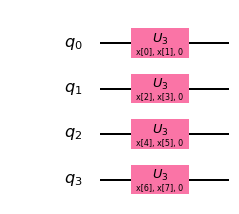

In [100]:
# Make feature map with encoder
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.algorithms import VQC
# from qiskit.aqua.compo
# feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement='linear')


X = [Parameter(f'x[{i}]') for i in range(data.shape[1])]

var_form = variational_forms.RYRZ(data.shape[1] // 2, depth=4)

qc = QuantumCircuit(data.shape[1] // 2)

for i in range(data.shape[1] // 2):
    qc.u3(X[2*i], X[2*i+1], 0, i) # Encoder

feature_map = qc #+ tmp1 + tmp2 
feature_map.draw('mpl')

In [101]:
#  QRAC input

# 5 K-fold on 4 mvp columns
from sklearn.model_selection import train_test_split

np.random.seed(123123)

kf = KFold(5, shuffle=True)


loss_logs_31 = []
results_31 = []
acc_f1s_train_31 = []
acc_f1s_test_31 = []


def train_ordinal_quantum(ro=0):
    seed = 10598

    vqc_ordinal_log = []
    def loss_history_callback(_, __, loss, ___):
        vqc_ordinal_log.append(loss)

    qsvm = VQC(SPSA(200), feature_map, var_form, training_input, callback=loss_history_callback)

    backend_options = {"method": "statevector_gpu"}
    backend = QasmSimulator(backend_options)
    
    quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed,optimization_level=3)


    result = qsvm.run(quantum_instance)
    
    y_pred = qsvm.predict(df_test_q)[1]
    y_pred_train = qsvm.predict(df_train_q)[1]


    # F1 score
    acc_f1_train = (np.mean(y_pred_train == y_train), f1_score(y_train, y_pred_train))
    acc_f1_test = (np.mean(y_pred == y_test), f1_score(y_test, y_pred))
    
    
    qsvm.save_model(f'models/bc_QRAC_fold_{ro}')
    
    return vqc_ordinal_log, result, acc_f1_train, acc_f1_test

for idx, (train_idxs, test_idxs) in enumerate(kf.split(df_data)):
    
    
    df_train_q, y_train = data[train_idxs], y[train_idxs]
    df_test_q, y_test = data[test_idxs], y[test_idxs]
    
    training_input = {
        0: df_train_q[y_train == 0],
        1: double(df_train_q[y_train == 1])
    }

    test_input = {
        0: df_test_q[y_test == 0],
        1: df_test_q[y_test == 1]
    }
    
    loss_log, result, acc_f1_train, acc_f1_test = train_ordinal_quantum(idx)
    loss_logs_31.append(loss_log)
    results_31.append(result)
    acc_f1s_train_31.append(acc_f1_train)
    acc_f1s_test_31.append(acc_f1_test)
    

/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
2020-07-29 04:52:32,416:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'qasm_simulator (None)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'swap', 'ccx', 'unitary', 'diagonal', 'initialize', 'cu1', 'cu2', 'cu3', 'cswap', 'mcx', 'mcy', 'mcz', 'mcu1', 'mcu2', 'mcu3', 'mcswap', 'multiplexer', 'kraus', 'roerror'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': 10598, 'optimizatio

2020-07-29 04:54:02,356:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:54:03,764:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.69725817326657
2020-07-29 04:54:03,765:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 10 of 25
2020-07-29 04:54:07,241:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:54:08,650:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7180591789398101
2020-07-29 04:54:11,836:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:54:13,208:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7169764836518715
2020-07-29 04:54:16,089:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:54:17,381:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.72323

2020-07-29 04:56:31,677:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:56:32,979:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7263656174026223
2020-07-29 04:56:36,424:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:56:37,763:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7069549639019475
2020-07-29 04:56:37,764:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 1: 0.7263656
2020-07-29 04:56:37,764:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 1: 0.7069550
2020-07-29 04:56:40,679:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:56:42,067:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.707195115948613
2020-07-29 04:56:45,534:qiskit.aqua.utils.run_circuits:INFO: Can't s

2020-07-29 04:58:17,884:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 12: 0.6504800
2020-07-29 04:58:17,884:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 12: 0.7042487
2020-07-29 04:58:20,792:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:58:22,146:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6896222692322267
2020-07-29 04:58:25,519:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 04:58:26,961:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7114734429064445
2020-07-29 04:58:26,962:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 13: 0.6896223
2020-07-29 04:58:26,962:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 13: 0.7114734
2020-07-29 04:58:29,943:qiskit.aqua.utils.run_

2020-07-29 05:00:06,311:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:00:07,612:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6266443017045061
2020-07-29 05:00:07,613:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 24: 0.6538057
2020-07-29 05:00:07,614:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 24: 0.6266443
2020-07-29 05:00:11,005:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:00:12,399:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6224573751135861
2020-07-29 05:00:15,493:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:00:16,873:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6169101711467145
2020-07-29 05:00:16,874:qiskit.aqua.components.optimizers.spsa:DE

2020-07-29 05:01:50,779:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:01:52,124:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6185997109378675
2020-07-29 05:01:55,503:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:01:56,859:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6212162052237502
2020-07-29 05:01:56,860:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 36: 0.6185997
2020-07-29 05:01:56,861:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 36: 0.6212162
2020-07-29 05:01:59,824:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:02:01,606:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6249222705498969
2020-07-29 05:02:04,730:qiskit.aqua.utils.run_circuits:INFO: Can'

2020-07-29 05:03:37,207:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 47: 0.6082368
2020-07-29 05:03:37,207:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 47: 0.6098597
2020-07-29 05:03:40,567:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:03:41,939:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6100406733944563
2020-07-29 05:03:45,016:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:03:46,335:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.610834376701737
2020-07-29 05:03:46,336:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 48: 0.6100407
2020-07-29 05:03:46,337:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 48: 0.6108344
2020-07-29 05:03:49,669:qiskit.aqua.utils.run_c

2020-07-29 05:05:24,785:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:05:26,142:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6059849409613527
2020-07-29 05:05:26,142:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 59: 0.6134004
2020-07-29 05:05:26,143:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 59: 0.6059849
2020-07-29 05:05:29,612:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:05:30,980:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6065141190197934
2020-07-29 05:05:33,929:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:05:35,375:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6089207169087374
2020-07-29 05:05:35,376:qiskit.aqua.components.optimizers.spsa:DE

2020-07-29 05:07:09,648:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:07:11,499:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6062074495770456
2020-07-29 05:07:14,542:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:07:15,929:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6059532407851724
2020-07-29 05:07:15,930:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 71: 0.6062074
2020-07-29 05:07:15,931:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 71: 0.6059532
2020-07-29 05:07:19,077:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:07:20,444:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6050451916543947
2020-07-29 05:07:23,326:qiskit.aqua.utils.run_circuits:INFO: Can'

2020-07-29 05:08:55,192:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 82: 0.6025768
2020-07-29 05:08:55,192:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 82: 0.6068391
2020-07-29 05:08:58,605:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:08:59,983:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6030301979344841
2020-07-29 05:09:03,017:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:09:04,382:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.604672004885653
2020-07-29 05:09:04,383:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 83: 0.6030302
2020-07-29 05:09:04,384:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 83: 0.6046720
2020-07-29 05:09:07,746:qiskit.aqua.utils.run_c

2020-07-29 05:10:42,848:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:10:44,191:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5993412053932624
2020-07-29 05:10:44,192:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 94: 0.6021102
2020-07-29 05:10:44,192:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 94: 0.5993412
2020-07-29 05:10:47,747:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:10:49,088:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5996601341926566
2020-07-29 05:10:51,982:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:10:53,323:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5980675332628992
2020-07-29 05:10:53,324:qiskit.aqua.components.optimizers.spsa:DE

2020-07-29 05:12:27,735:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:12:29,512:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5988461554698419
2020-07-29 05:12:32,445:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:12:33,806:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5919308859446142
2020-07-29 05:12:33,807:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 106: 0.5988462
2020-07-29 05:12:33,807:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 106: 0.5919309
2020-07-29 05:12:36,730:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:12:38,132:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5975868413257471
2020-07-29 05:12:41,092:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-07-29 05:14:12,998:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 117: 0.5886622
2020-07-29 05:14:12,998:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 117: 0.5912599
2020-07-29 05:14:16,462:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:14:17,831:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5930190591095801
2020-07-29 05:14:20,858:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:14:22,238:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.593673576457213
2020-07-29 05:14:22,239:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 118: 0.5930191
2020-07-29 05:14:22,239:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 118: 0.5936736
2020-07-29 05:14:25,674:qiskit.aqua.utils.r

2020-07-29 05:16:00,694:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:16:02,020:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5861692087925964
2020-07-29 05:16:02,021:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 129: 0.5868319
2020-07-29 05:16:02,021:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 129: 0.5861692
2020-07-29 05:16:05,475:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:16:06,831:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5838404076962578
2020-07-29 05:16:09,678:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:16:11,164:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5912161045703719
2020-07-29 05:16:11,165:qiskit.aqua.components.optimizers.spsa:

2020-07-29 05:17:44,913:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:17:46,239:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5846218490571445
2020-07-29 05:17:49,082:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:17:50,440:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.585832275833452
2020-07-29 05:17:50,441:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 141: 0.5846218
2020-07-29 05:17:50,442:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 141: 0.5858323
2020-07-29 05:17:53,952:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:17:55,334:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5852187868525192
2020-07-29 05:17:58,243:qiskit.aqua.utils.run_circuits:INFO: Can

2020-07-29 05:19:31,349:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 152: 0.5816835
2020-07-29 05:19:31,350:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 152: 0.5865799
2020-07-29 05:19:34,773:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:19:36,153:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5843353731618014
2020-07-29 05:19:39,643:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:19:40,930:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5884813575617106
2020-07-29 05:19:40,931:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 153: 0.5843354
2020-07-29 05:19:40,932:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 153: 0.5884814
2020-07-29 05:19:44,434:qiskit.aqua.utils.

2020-07-29 05:21:19,932:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:21:21,302:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5840581637456802
2020-07-29 05:21:21,303:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 164: 0.5865461
2020-07-29 05:21:21,304:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 164: 0.5840582
2020-07-29 05:21:24,235:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:21:26,088:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5843376174479441
2020-07-29 05:21:29,131:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:21:30,510:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5845096116100618
2020-07-29 05:21:30,511:qiskit.aqua.components.optimizers.spsa:

2020-07-29 05:24:32,096:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:24:33,476:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5836100601906844
2020-07-29 05:24:33,477:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 185: 0.5882228
2020-07-29 05:24:33,478:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 185: 0.5836101
2020-07-29 05:24:36,386:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:24:37,693:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5852741514297428
2020-07-29 05:24:41,194:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:24:42,624:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5804555200191025
2020-07-29 05:24:42,624:qiskit.aqua.components.optimizers.spsa:

2020-07-29 05:26:16,606:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:26:17,964:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5805009611288248
2020-07-29 05:26:20,816:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:26:22,630:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5822242043826159
2020-07-29 05:26:22,631:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 197: 0.5805010
2020-07-29 05:26:22,632:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 197: 0.5822242
2020-07-29 05:26:25,770:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:26:27,174:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5874317302666
2020-07-29 05:26:30,068:qiskit.aqua.utils.run_circuits:INFO: Can't

2020-07-29 05:27:20,810:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:27:22,654:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.754469905220464
2020-07-29 05:27:25,842:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:27:27,221:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7071491323885859
2020-07-29 05:27:30,335:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:27:31,702:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7195112061828023
2020-07-29 05:27:34,609:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:27:36,394:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7404719030965548
2020-07-29 05:27:36,395:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration ste

2020-07-29 05:29:56,898:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7225366454823646
2020-07-29 05:30:00,283:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:30:01,657:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7132905104756121
2020-07-29 05:30:04,643:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:30:05,992:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7411787643046438
2020-07-29 05:30:08,926:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:30:10,789:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7121096305474696
2020-07-29 05:30:13,765:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:30:15,108:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate b

2020-07-29 05:31:58,910:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6996342844086098
2020-07-29 05:31:58,911:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 8: 0.6919428
2020-07-29 05:31:58,912:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 8: 0.6996343
2020-07-29 05:32:02,277:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:32:03,599:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6953673226672946
2020-07-29 05:32:06,519:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:32:08,434:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.695628605776822
2020-07-29 05:32:08,435:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 9: 0.6953673
2020-07-29 05:32:08,436:qiskit.aqua.components.optimizers.sp

2020-07-29 05:33:42,994:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6626543814132998
2020-07-29 05:33:45,999:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:33:47,825:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6330572175775595
2020-07-29 05:33:47,826:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 20: 0.6626544
2020-07-29 05:33:47,827:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 20: 0.6330572
2020-07-29 05:33:50,823:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:33:52,190:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6453268543983242
2020-07-29 05:33:55,338:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:33:56,646:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-29 05:35:26,388:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 31: 0.6281860
2020-07-29 05:35:29,423:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:35:30,808:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6185750800303207
2020-07-29 05:35:33,875:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:35:35,213:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6363866372248594
2020-07-29 05:35:35,214:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 32: 0.6185751
2020-07-29 05:35:35,215:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 32: 0.6363866
2020-07-29 05:35:38,612:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:35:40,025:qiskit.aqua.algorithms.classifi

2020-07-29 05:37:15,753:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6147570366229824
2020-07-29 05:37:15,754:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 43: 0.6132160
2020-07-29 05:37:15,755:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 43: 0.6147570
2020-07-29 05:37:18,787:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:37:20,130:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6098760682517554
2020-07-29 05:37:23,242:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:37:24,654:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6146564294888853
2020-07-29 05:37:24,655:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 44: 0.6098761
2020-07-29 05:37:24,656:qiskit.aqua.components.optimizer

2020-07-29 05:38:59,490:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6116809317326648
2020-07-29 05:39:02,333:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:39:04,115:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6030543791019015
2020-07-29 05:39:04,116:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 55: 0.6116809
2020-07-29 05:39:04,117:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 55: 0.6030544
2020-07-29 05:39:07,014:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:39:08,357:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6154880342877261
2020-07-29 05:39:11,324:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:39:12,639:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-07-29 05:40:43,760:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 66: 0.6063804
2020-07-29 05:40:46,699:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:40:48,022:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6020022612146154
2020-07-29 05:40:50,891:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:40:52,211:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.601885242262154
2020-07-29 05:40:52,212:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 67: 0.6020023
2020-07-29 05:40:52,213:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 67: 0.6018852
2020-07-29 05:40:55,666:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:40:57,028:qiskit.aqua.algorithms.classifie

2020-07-29 05:42:33,102:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6036613774180599
2020-07-29 05:42:33,103:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 78: 0.6036201
2020-07-29 05:42:33,104:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 78: 0.6036614
2020-07-29 05:42:36,122:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:42:37,507:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6022709417699081
2020-07-29 05:42:40,351:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:42:41,657:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6037123946205499
2020-07-29 05:42:41,658:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 79: 0.6022709
2020-07-29 05:42:41,658:qiskit.aqua.components.optimizer

2020-07-29 05:44:17,110:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6024731460543895
2020-07-29 05:44:20,116:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:44:21,435:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.604337215729676
2020-07-29 05:44:21,436:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 90: 0.6024731
2020-07-29 05:44:21,436:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 90: 0.6043372
2020-07-29 05:44:24,412:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:44:26,269:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6042928028373887
2020-07-29 05:44:29,220:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:44:30,564:qiskit.aqua.algorithms.classifiers.vqc:DEB

2020-07-29 05:45:59,834:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 101: 0.6035775
2020-07-29 05:46:03,182:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:46:04,527:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.598002080622327
2020-07-29 05:46:07,516:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:46:08,870:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6036697279653492
2020-07-29 05:46:08,871:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 102: 0.5980021
2020-07-29 05:46:08,871:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 102: 0.6036697
2020-07-29 05:46:12,245:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:46:13,572:qiskit.aqua.algorithms.classi

2020-07-29 05:47:48,819:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6049022954235077
2020-07-29 05:47:48,820:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 113: 0.6009546
2020-07-29 05:47:48,821:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 113: 0.6049023
2020-07-29 05:47:51,843:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:47:53,212:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6003978998658586
2020-07-29 05:47:56,173:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:47:57,550:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6004427881630326
2020-07-29 05:47:57,551:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 114: 0.6003979
2020-07-29 05:47:57,551:qiskit.aqua.components.optimi

2020-07-29 05:49:32,443:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5971525290563414
2020-07-29 05:49:35,413:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:49:36,716:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5992799802310351
2020-07-29 05:49:36,717:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 125: 0.5971525
2020-07-29 05:49:36,718:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 125: 0.5992800
2020-07-29 05:49:39,594:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:49:41,382:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6001550954677201
2020-07-29 05:49:44,486:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:49:45,862:qiskit.aqua.algorithms.classifiers.vqc:

2020-07-29 05:51:16,243:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 136: 0.5972313
2020-07-29 05:51:19,786:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:51:21,182:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5997403293159823
2020-07-29 05:51:24,246:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:51:25,630:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5968176312034479
2020-07-29 05:51:25,631:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 137: 0.5997403
2020-07-29 05:51:25,631:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 137: 0.5968176
2020-07-29 05:51:29,054:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:51:30,390:qiskit.aqua.algorithms.class

2020-07-29 05:53:05,221:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5978515503877911
2020-07-29 05:53:05,222:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 148: 0.5961715
2020-07-29 05:53:05,223:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 148: 0.5978516
2020-07-29 05:53:08,289:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:53:09,695:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.600216075877232
2020-07-29 05:53:12,492:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:53:13,803:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5964699386762791
2020-07-29 05:53:13,804:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 149: 0.6002161
2020-07-29 05:53:13,805:qiskit.aqua.components.optimiz

2020-07-29 05:54:48,167:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5994703237507245
2020-07-29 05:54:51,277:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:54:52,621:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5980231717546873
2020-07-29 05:54:52,622:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 160: 0.5994703
2020-07-29 05:54:52,622:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 160: 0.5980232
2020-07-29 05:54:55,484:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:54:57,272:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5991132578231659
2020-07-29 05:55:00,275:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:55:01,644:qiskit.aqua.algorithms.classifiers.vqc:

2020-07-29 05:56:31,673:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 171: 0.5969047
2020-07-29 05:56:35,006:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:56:36,340:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5947143852838442
2020-07-29 05:56:39,157:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:56:40,479:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5986888975969547
2020-07-29 05:56:40,480:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 172: 0.5947144
2020-07-29 05:56:40,481:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 172: 0.5986889
2020-07-29 05:56:43,914:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:56:45,277:qiskit.aqua.algorithms.class

2020-07-29 05:58:19,931:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5950685425764489
2020-07-29 05:58:19,932:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 183: 0.5961003
2020-07-29 05:58:19,932:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 183: 0.5950685
2020-07-29 05:58:22,822:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:58:24,168:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5998347510389629
2020-07-29 05:58:26,930:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 05:58:28,229:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5965043940258602
2020-07-29 05:58:28,230:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 184: 0.5998348
2020-07-29 05:58:28,231:qiskit.aqua.components.optimi

2020-07-29 06:00:03,915:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5944259562345051
2020-07-29 06:00:06,849:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:00:08,175:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5951918558154269
2020-07-29 06:00:08,175:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 195: 0.5944260
2020-07-29 06:00:08,176:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 195: 0.5951919
2020-07-29 06:00:11,057:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:00:12,879:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5982137357320314
2020-07-29 06:00:15,828:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:00:17,211:qiskit.aqua.algorithms.classifiers.vqc:

2020-07-29 06:00:58,008:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7372936394221467
2020-07-29 06:01:00,866:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:01:02,208:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7231256060400508
2020-07-29 06:01:05,674:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:01:07,039:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7086005089373563
2020-07-29 06:01:09,973:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:01:11,898:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7591256216584413
2020-07-29 06:01:14,901:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:01:16,215:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate b

2020-07-29 06:03:39,565:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7614216857259029
2020-07-29 06:03:42,576:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:03:43,900:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7190069202230067
2020-07-29 06:03:46,797:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:03:48,648:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7354525224381121
2020-07-29 06:03:51,677:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:03:53,064:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7095869806921599
2020-07-29 06:03:56,112:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:03:57,481:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate b

2020-07-29 06:05:46,198:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 6: 0.7336990
2020-07-29 06:05:46,199:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 6: 0.7259214
2020-07-29 06:05:49,533:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:05:50,880:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7056593917947596
2020-07-29 06:05:54,452:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:05:55,841:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7531545467828417
2020-07-29 06:05:55,842:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 7: 0.7056594
2020-07-29 06:05:55,842:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 7: 0.7531545
2020-07-29 06:05:59,006:qiskit.aqua.utils.run_circ

2020-07-29 06:07:34,199:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:07:35,980:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6922781223413796
2020-07-29 06:07:35,981:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 18: 0.6655011
2020-07-29 06:07:35,981:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 18: 0.6922781
2020-07-29 06:07:39,093:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:07:40,463:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6692639463082337
2020-07-29 06:07:43,859:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:07:45,189:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6659077342487268
2020-07-29 06:07:45,190:qiskit.aqua.components.optimizers.spsa:DE

2020-07-29 06:09:19,118:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:09:20,416:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6414893228501586
2020-07-29 06:09:23,417:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:09:24,739:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6402106526679778
2020-07-29 06:09:24,740:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 30: 0.6414893
2020-07-29 06:09:24,740:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 30: 0.6402107
2020-07-29 06:09:28,119:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:09:29,490:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6372152282885464
2020-07-29 06:09:32,461:qiskit.aqua.utils.run_circuits:INFO: Can'

2020-07-29 06:11:05,589:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 41: 0.6256959
2020-07-29 06:11:05,589:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 41: 0.6335187
2020-07-29 06:11:08,538:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:11:09,867:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6411167240515652
2020-07-29 06:11:12,765:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:11:14,161:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6314954850991568
2020-07-29 06:11:14,162:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 42: 0.6411167
2020-07-29 06:11:14,163:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 42: 0.6314955
2020-07-29 06:11:17,581:qiskit.aqua.utils.run_

2020-07-29 06:12:53,283:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:12:54,619:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6229013425847332
2020-07-29 06:12:54,620:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 53: 0.6159023
2020-07-29 06:12:54,620:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 53: 0.6229013
2020-07-29 06:12:57,544:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:12:59,362:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6167004628070082
2020-07-29 06:13:02,479:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:13:03,797:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.617617158441991
2020-07-29 06:13:03,798:qiskit.aqua.components.optimizers.spsa:DEB

2020-07-29 06:14:37,626:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:14:39,427:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6087118608798887
2020-07-29 06:14:42,436:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:14:43,802:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6063436446041028
2020-07-29 06:14:43,803:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 65: 0.6087119
2020-07-29 06:14:43,804:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 65: 0.6063436
2020-07-29 06:14:47,055:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:14:48,415:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6094408194365643
2020-07-29 06:14:51,287:qiskit.aqua.utils.run_circuits:INFO: Can'

2020-07-29 06:16:24,757:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 76: 0.6037012
2020-07-29 06:16:24,758:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 76: 0.6090292
2020-07-29 06:16:28,180:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:16:29,578:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6054001797846563
2020-07-29 06:16:32,380:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:16:34,153:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6043000164470032
2020-07-29 06:16:34,154:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 77: 0.6054002
2020-07-29 06:16:34,155:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 77: 0.6043000
2020-07-29 06:16:37,193:qiskit.aqua.utils.run_

2020-07-29 06:18:13,289:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:18:14,617:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.595680646226453
2020-07-29 06:18:14,618:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 88: 0.6021983
2020-07-29 06:18:14,618:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 88: 0.5956806
2020-07-29 06:18:17,534:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:18:19,404:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5913488198827747
2020-07-29 06:18:22,389:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:18:23,816:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5991182779564873
2020-07-29 06:18:23,817:qiskit.aqua.components.optimizers.spsa:DEB

2020-07-29 06:19:59,456:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:20:00,851:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5948682680222804
2020-07-29 06:20:03,818:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:20:05,258:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5892161076451881
2020-07-29 06:20:05,259:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 100: 0.5948683
2020-07-29 06:20:05,259:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 100: 0.5892161
2020-07-29 06:20:08,583:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:20:09,962:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5891224924352458
2020-07-29 06:20:13,058:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-07-29 06:21:45,776:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 111: 0.5873006
2020-07-29 06:21:45,777:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 111: 0.5898475
2020-07-29 06:21:49,164:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:21:50,491:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5849841475720603
2020-07-29 06:21:53,330:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:21:55,110:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5869765279877441
2020-07-29 06:21:55,111:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 112: 0.5849841
2020-07-29 06:21:55,112:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 112: 0.5869765
2020-07-29 06:21:58,211:qiskit.aqua.utils.

2020-07-29 06:23:33,625:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:23:34,916:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5839480803720644
2020-07-29 06:23:34,917:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 123: 0.5825427
2020-07-29 06:23:34,918:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 123: 0.5839481
2020-07-29 06:23:38,230:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:23:39,624:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.586385346626671
2020-07-29 06:23:42,697:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:23:44,067:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.592859285675241
2020-07-29 06:23:44,068:qiskit.aqua.components.optimizers.spsa:DE

2020-07-29 06:25:17,716:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:25:19,463:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5820452920588991
2020-07-29 06:25:22,485:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:25:23,856:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5803709428391661
2020-07-29 06:25:23,856:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 135: 0.5820453
2020-07-29 06:25:23,857:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 135: 0.5803709
2020-07-29 06:25:27,442:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:25:28,778:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5826058544549373
2020-07-29 06:25:32,092:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-07-29 06:27:05,056:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 146: 0.5803572
2020-07-29 06:27:05,056:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 146: 0.5765360
2020-07-29 06:27:08,418:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:27:09,832:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.577628996193693
2020-07-29 06:27:12,917:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:27:14,243:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5801080120802371
2020-07-29 06:27:14,244:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 147: 0.5776290
2020-07-29 06:27:14,244:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 147: 0.5801080
2020-07-29 06:27:17,106:qiskit.aqua.utils.r

2020-07-29 06:28:52,459:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:28:53,805:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5741485379075552
2020-07-29 06:28:53,806:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 158: 0.5784743
2020-07-29 06:28:53,807:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 158: 0.5741485
2020-07-29 06:28:56,535:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:28:57,888:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5757665759669346
2020-07-29 06:29:01,385:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:29:02,788:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5793970621903514
2020-07-29 06:29:02,789:qiskit.aqua.components.optimizers.spsa:

2020-07-29 06:30:37,194:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:30:38,545:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5743020266653436
2020-07-29 06:30:41,487:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:30:42,810:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5753191511060335
2020-07-29 06:30:42,811:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 170: 0.5743020
2020-07-29 06:30:42,811:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 170: 0.5753192
2020-07-29 06:30:46,384:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:30:47,797:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5766551886972258
2020-07-29 06:30:50,734:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-07-29 06:32:21,580:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 181: 0.5758622
2020-07-29 06:32:21,581:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 181: 0.5741132
2020-07-29 06:32:25,150:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:32:26,533:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5770049646170866
2020-07-29 06:32:29,525:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:32:30,872:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5735002025174907
2020-07-29 06:32:30,873:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 182: 0.5770050
2020-07-29 06:32:30,874:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 182: 0.5735002
2020-07-29 06:32:33,671:qiskit.aqua.utils.

2020-07-29 06:34:09,418:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:34:10,778:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5731475747423136
2020-07-29 06:34:10,779:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 193: 0.5744872
2020-07-29 06:34:10,780:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 193: 0.5731476
2020-07-29 06:34:14,108:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:34:15,407:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5761450196549633
2020-07-29 06:34:18,799:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:34:20,181:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5711003211722656
2020-07-29 06:34:20,181:qiskit.aqua.components.optimizers.spsa:

2020-07-29 06:35:15,138:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: SPSA does not support bounds. It will be ignored.
2020-07-29 06:35:15,139:qiskit.aqua.components.optimizers.spsa:DEBUG: Parameters: [0.62831853 0.1        0.602      0.101      0.        ]
2020-07-29 06:35:15,139:qiskit.aqua.components.optimizers.spsa:DEBUG: Calibration...
2020-07-29 06:35:15,140:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 0 of 25
2020-07-29 06:35:18,662:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:35:20,079:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6935665247454924
2020-07-29 06:35:22,997:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:35:24,360:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6978327375538236
2020-07-29 06:35:27,731:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation

2020-07-29 06:37:45,859:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:37:47,262:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7008833570469178
2020-07-29 06:37:50,198:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:37:51,600:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6957271995984684
2020-07-29 06:37:54,526:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:37:55,848:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6888172119417019
2020-07-29 06:37:59,385:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:38:00,742:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6904416441396997
2020-07-29 06:38:03,784:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validat

2020-07-29 06:39:52,910:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 5: 0.6969313
2020-07-29 06:39:56,273:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:39:57,657:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6663359158124554
2020-07-29 06:40:00,652:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:40:02,045:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7017316379808761
2020-07-29 06:40:02,046:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 6: 0.6663359
2020-07-29 06:40:02,046:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 6: 0.7017316
2020-07-29 06:40:04,926:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:40:06,272:qiskit.aqua.algorithms.classifiers

2020-07-29 06:41:41,155:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7191770025653141
2020-07-29 06:41:41,156:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 17: 0.7004797
2020-07-29 06:41:41,157:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 17: 0.7191770
2020-07-29 06:41:44,057:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:41:45,870:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7266397831373291
2020-07-29 06:41:48,895:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-07-29 06:41:50,237:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7031793994450789
2020-07-29 06:41:50,238:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 18: 0.7266398
2020-07-29 06:41:50,238:qiskit.aqua.components.optimizer

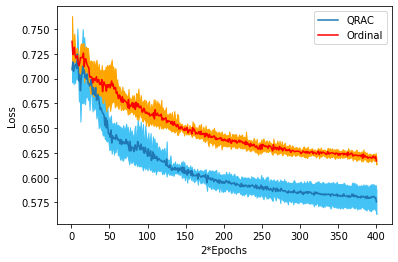

In [116]:
mean_epoch = np.mean(loss_logs_31, axis=0)[-400:]
std_epoch = np.std(loss_logs_31, axis=0)[-400:]

X = np.arange(1,401)
plt.plot(X, mean_epoch, label='QRAC')
plt.fill_between(X, mean_epoch - std_epoch, mean_epoch + std_epoch,color='#42c2f5')

mean_epoch = np.mean(loss_logs, axis=0)[-400:]
std_epoch = np.std(loss_logs, axis=0)[-400:]

X = np.arange(1,401)
plt.plot(X, mean_epoch, label='Ordinal', color='r')
plt.fill_between(X, mean_epoch - std_epoch, mean_epoch + std_epoch,color='orange')

plt.xlabel('2*Epochs')
plt.ylabel('Loss')

plt.legend()

In [114]:
import pickle

ordinal_record = {
    'loss_logs': loss_logs,
    'result': results,
    'acc_f1s_train': acc_f1s_train,
    'acc_f1s_test': acc_f1s_test
}

qrac_record = {
    'loss_logs': loss_logs_31,
    'result': results_31,
    'acc_f1s_train': acc_f1s_train_31,
    'acc_f1s_test': acc_f1s_test_31
}

with open('results/bc_ordinal_record.pk', 'wb') as f:
    pickle.dump(ordinal_record, f)
    
with open('results/bc_qrac_record.pk', 'wb') as f:
    pickle.dump(qrac_record, f)

In [109]:
np.mean(acc_f1s_train, axis=0), np.mean(acc_f1s_test, axis=0)

(array([0.67307132, 0.51882367]), array([0.59467635, 0.39367019]))

In [115]:
np.mean(acc_f1s_train_31, axis=0),np.mean(acc_f1s_test_31, axis=0)

(array([0.7386348, 0.5620016]), array([0.69945554, 0.49910203]))

In [46]:
# 

seed = 10598

vqc_encode_only_log = []
def loss_history_callback(_, __, loss, ___):
    vqc_encode_only_log.append(loss)

qsvm_encode = VQC(COBYLA(100), feature_map, var_form, training_input, callback=loss_history_callback)

# provider = IBMQ.get_provider(hub='ibm-q-utokyo')
# backend = provider.get_backend('ibmq_johannesburg')

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)


result = qsvm_encode.run(quantum_instance)


/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  if __name__ == '__main__':
2020-07-08 02:30:48,544:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'qasm_simulator (BasicAer)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'id', 'unitary'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': 10598, 'optimization_level': None}
RunConfig(max_credits=10, seed_simulator=10598, shots=1024)
{'timeout': None}
{}
{}
Measurement mitigation: None
2020-07-08 02:30:48,546:qiskit.aqua.algorithms.v

2020-07-08 02:37:03,970:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6777079585667909
2020-07-08 02:37:10,594:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6595710944939288
2020-07-08 02:37:17,268:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6821093552281404
2020-07-08 02:37:23,824:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6488349198163084
2020-07-08 02:37:30,615:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7208739275585728
2020-07-08 02:37:37,114:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6539109840909156
2020-07-08 02:37:43,823:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6570022492068676
2020-07-08 02:37:50,387:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6629536475267617
2020-07-08 02:37:56,863:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch

preduction of datapoints:


In [47]:
# Train acc

y_pred = qsvm_encode.predict(df_train_encode)[1]

np.mean(y_pred == y_train), f1_score(y_train, y_pred)

2020-07-08 02:43:47,074:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


(0.6885964912280702, 0.5359477124183006)

In [48]:
# Test acc

y_pred = qsvm_encode.predict(df_test_encode)[1]

np.mean(y_pred == y_test), f1_score(y_test, y_pred)

2020-07-08 02:43:53,199:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


(0.6551724137931034, 0.4736842105263159)

In [49]:
qsvm_encode.save_model('models/VQC_just_encode_model_3_feature')

# Model 2

In [179]:
df_test_encode.shape

(58, 8)

/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.


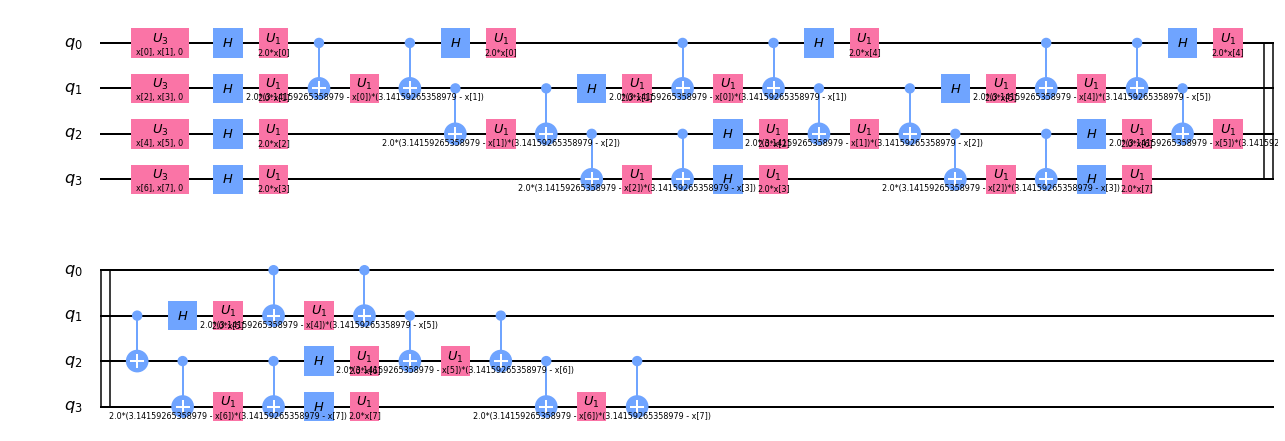

In [50]:
# Make feature map with encoder
from qiskit.circuit import QuantumCircuit, Parameter


num_qubits = data.shape[1] // 2
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement='linear')


X = [Parameter(f'x[{i}]') for i in range(num_qubits * 2)]

var_form = variational_forms.RYRZ(num_qubits)

qc = QuantumCircuit(num_qubits)

for i in range(num_qubits):
    qc.u3(X[2*i], X[2*i+1], 0, i) # Encoder
    

# Reassign the circuit variable
tmp1 = feature_map.assign_parameters(X[:num_qubits])
tmp2 = feature_map.assign_parameters(X[num_qubits:])

feature_map = qc + tmp1 + tmp2 
feature_map.draw('mpl')

In [51]:
# 

seed = 10598

vqc_encode_zz_log = []
def loss_history_callback(_, __, loss, ___):
    vqc_encode_zz_log.append(loss)

qsvm_encode = VQC(COBYLA(100), feature_map, var_form, training_input, callback=loss_history_callback)

# provider = IBMQ.get_provider(hub='ibm-q-utokyo')
# backend = provider.get_backend('ibmq_johannesburg')

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)


result = qsvm_encode.run(quantum_instance)


/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  if __name__ == '__main__':
2020-07-08 02:43:56,049:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'qasm_simulator (BasicAer)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'id', 'unitary'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': 10598, 'optimization_level': None}
RunConfig(max_credits=10, seed_simulator=10598, shots=1024)
{'timeout': None}
{}
{}
Measurement mitigation: None
2020-07-08 02:43:56,051:qiskit.aqua.algorithms.v

2020-07-08 02:54:13,054:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6372335164986936
2020-07-08 02:54:23,016:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6128811323989395
2020-07-08 02:54:33,045:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6164393309027493
2020-07-08 02:54:45,150:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6321953926332909
2020-07-08 02:54:55,009:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6337408363881105
2020-07-08 02:55:09,270:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6279022658805908
2020-07-08 02:55:24,307:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6430431076647046
2020-07-08 02:55:39,968:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6215727069334842
2020-07-08 02:55:50,550:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch

preduction of datapoints:


In [52]:
# Train acc
y_pred = qsvm_encode.predict(df_train_encode)[1]

np.mean(y_pred == y_train), f1_score(y_train, y_pred)

2020-07-08 03:05:16,854:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


(0.7017543859649122, 0.5903614457831325)

In [53]:
# Test acc

y_pred = qsvm_encode.predict(df_test_encode)[1]

np.mean(y_pred == y_test), f1_score(y_test, y_pred)

2020-07-08 03:05:26,118:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


(0.46551724137931033, 0.24390243902439024)

In [54]:
qsvm_encode.save_model('models/VQC_encode_model_wt_ZZ_3_feature')

# Real Device

/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


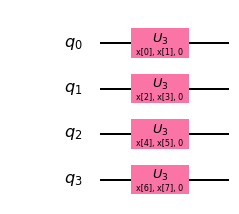

In [60]:
# Make feature map with encoder
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.algorithms import VQC
# from qiskit.aqua.compo
# feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement='linear')


X = [Parameter(f'x[{i}]') for i in range(data.shape[1])]

var_form = variational_forms.RYRZ(data.shape[1] // 2)

qc = QuantumCircuit(data.shape[1] // 2)

for i in range(data.shape[1] // 2):
    qc.u3(X[2*i], X[2*i+1], 0, i) # Encoder

feature_map = qc #+ tmp1 + tmp2 
feature_map.draw('mpl')

In [72]:
# 

seed = 10598

vqc_encode_only_real_log = []
def loss_history_callback(_, __, loss, ___):
    vqc_encode_only_real_log.append(loss)

qsvm_encode = VQC(COBYLA(100), feature_map, var_form, training_input, callback=loss_history_callback)

provider = IBMQ.get_provider(hub='ibm-q-utokyo')
backend = provider.get_backend('ibmq_johannesburg')

# backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed, optimization_level=3)


result = qsvm_encode.run(quantum_instance)


/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  if __name__ == '__main__':
2020-07-08 20:47:41,374:qiskit.aqua.quantum_instance:WARNING: The skip Qobj validation does not work for IBMQ provider. Disable it.
2020-07-08 20:47:41,377:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'ibmq_johannesburg (<AccountProvider for IBMQ(hub='ibm-q-utokyo', group='internal', project='qc2020s')>)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'id'], 'coupling_map': [[0, 1], [0, 5], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 

2020-07-08 20:51:09,704:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b26573344e0013341d71, status: JobStatus.RUNNING
2020-07-08 20:51:15,043:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b26573344e0013341d71, status: JobStatus.RUNNING
2020-07-08 20:51:20,726:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b26573344e0013341d71, status: JobStatus.RUNNING
2020-07-08 20:51:26,112:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b26573344e0013341d71, status: JobStatus.RUNNING
2020-07-08 20:51:31,773:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b26573344e0013341d71, status: JobStatus.RUNNING
2020-07-08 20:51:37,411:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b26573344e0013341d71, status: JobStatus.RUNNING
2020-07-08 20:51:43,058:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b26573344e0013341d71, status: JobStatus.RUNNING
2020-07-08 20:51:48,477:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b26573344e0013341d71, status: JobStatus.RUNNING
2020-07-08 20:51:54,149:qiskit.a

2020-07-08 20:57:00,015:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b46b73344e0013341d85, status: JobStatus.RUNNING
2020-07-08 20:57:05,666:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b46b73344e0013341d85, status: JobStatus.RUNNING
2020-07-08 20:57:11,311:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b46b73344e0013341d85, status: JobStatus.RUNNING
2020-07-08 20:57:16,954:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b46b73344e0013341d85, status: JobStatus.RUNNING
2020-07-08 20:57:22,628:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b46b73344e0013341d85, status: JobStatus.RUNNING
2020-07-08 20:57:28,282:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b46b73344e0013341d85, status: JobStatus.RUNNING
2020-07-08 20:57:33,910:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b46b73344e0013341d85, status: JobStatus.RUNNING
2020-07-08 20:57:39,549:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b46b73344e0013341d85, status: JobStatus.RUNNING
2020-07-08 20:57:45,258:qiskit.a

2020-07-08 21:03:10,567:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b572790ba00012718dc8, status: JobStatus.RUNNING
2020-07-08 21:03:16,229:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b572790ba00012718dc8, status: JobStatus.RUNNING
2020-07-08 21:03:21,868:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b572790ba00012718dc8, status: JobStatus.RUNNING
2020-07-08 21:03:27,256:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b572790ba00012718dc8, status: JobStatus.RUNNING
2020-07-08 21:03:32,594:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b572790ba00012718dc8, status: JobStatus.RUNNING
2020-07-08 21:03:38,265:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b572790ba00012718dc8, status: JobStatus.RUNNING
2020-07-08 21:03:44,040:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b572790ba00012718dc8, status: JobStatus.RUNNING
2020-07-08 21:03:49,677:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b572790ba00012718dc8, status: JobStatus.RUNNING
2020-07-08 21:03:55,294:qiskit.a

2020-07-08 21:09:10,988:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b676111e500014f72117, status: JobStatus.RUNNING
2020-07-08 21:09:19,740:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f05b676111e500014f72117
2020-07-08 21:09:19,896:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7130390106698647
2020-07-08 21:09:41,567:qiskit.aqua.utils.run_circuits:INFO: Backend status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x7f9d49394198>
2020-07-08 21:09:41,572:qiskit.aqua.utils.run_circuits:INFO: There are 1 jobs are submitted.
2020-07-08 21:09:41,574:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f05b77fcacdac0012e1c01c']
2020-07-08 21:09:41,576:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f05b77fcacdac0012e1c01c
2020-07-08 21:09:42,174:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b77fcacdac0012e1c01c, status: JobStatus.VALIDATING
2020-07-08 21:09:47,729:qiskit.aqua.utils.run_circuits:IN

2020-07-08 21:15:12,018:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b8804e527c00122ef129, status: JobStatus.RUNNING
2020-07-08 21:15:17,736:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b8804e527c00122ef129, status: JobStatus.RUNNING
2020-07-08 21:15:23,372:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b8804e527c00122ef129, status: JobStatus.RUNNING
2020-07-08 21:15:28,866:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b8804e527c00122ef129, status: JobStatus.RUNNING
2020-07-08 21:15:34,493:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b8804e527c00122ef129, status: JobStatus.RUNNING
2020-07-08 21:15:40,464:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b8804e527c00122ef129, status: JobStatus.RUNNING
2020-07-08 21:15:45,977:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b8804e527c00122ef129, status: JobStatus.RUNNING
2020-07-08 21:15:51,378:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b8804e527c00122ef129, status: JobStatus.RUNNING
2020-07-08 21:15:57,063:qiskit.a

2020-07-08 21:21:21,973:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b97ccacdac0012e1c02c, status: JobStatus.RUNNING
2020-07-08 21:21:27,697:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b97ccacdac0012e1c02c, status: JobStatus.RUNNING
2020-07-08 21:21:33,410:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b97ccacdac0012e1c02c, status: JobStatus.RUNNING
2020-07-08 21:21:38,992:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b97ccacdac0012e1c02c, status: JobStatus.RUNNING
2020-07-08 21:21:44,604:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b97ccacdac0012e1c02c, status: JobStatus.RUNNING
2020-07-08 21:21:50,333:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b97ccacdac0012e1c02c, status: JobStatus.RUNNING
2020-07-08 21:21:55,935:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b97ccacdac0012e1c02c, status: JobStatus.RUNNING
2020-07-08 21:22:01,331:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05b97ccacdac0012e1c02c, status: JobStatus.RUNNING
2020-07-08 21:22:06,972:qiskit.a

2020-07-08 21:27:31,920:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:27:37,609:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:27:42,964:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:27:48,634:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:27:54,103:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:27:59,795:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:28:05,413:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:28:11,046:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:28:16,670:qiskit.aqua.utils.run_circuits:I

2020-07-08 21:34:03,577:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:34:08,937:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:34:14,628:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:34:20,039:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:34:25,644:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:34:30,979:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:34:36,578:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:34:42,255:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:34:47,581:qiskit.aqua.utils.run_circuits:I

2020-07-08 21:40:32,282:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:40:37,933:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:40:43,288:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:40:48,962:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:40:54,659:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:41:00,314:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:41:05,696:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:41:11,364:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:41:16,699:qiskit.aqua.utils.run_circuits:I

2020-07-08 21:47:04,076:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:47:09,708:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:47:15,116:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:47:20,471:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:47:26,204:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:47:31,837:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:47:37,466:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:47:43,160:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:47:48,777:qiskit.aqua.utils.run_circuits:I

2020-07-08 21:53:34,762:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:53:40,407:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:53:46,032:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:53:51,648:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:53:56,946:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:54:02,687:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:54:08,311:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:54:13,984:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 21:54:19,616:qiskit.aqua.utils.run_circuits:I

2020-07-08 22:00:08,504:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:00:14,244:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:00:19,638:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:00:25,363:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:00:31,054:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:00:36,694:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:00:42,343:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:00:48,382:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:00:54,037:qiskit.aqua.utils.run_circuits:I

2020-07-08 22:06:41,768:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:06:47,420:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:06:57,239:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:07:02,865:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:07:08,348:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:07:13,974:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:07:19,731:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:07:25,400:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:07:31,023:qiskit.aqua.utils.run_circuits:I

2020-07-08 22:13:19,281:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:13:24,626:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:13:30,041:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:13:36,638:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:13:42,132:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:13:47,800:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:13:53,411:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:13:58,741:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:14:04,493:qiskit.aqua.utils.run_circuits:I

2020-07-08 22:19:52,418:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:19:57,921:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:20:03,296:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:20:08,656:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:20:14,318:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:20:19,659:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:20:25,505:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:20:30,852:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4 is queued at position 1
2020-07-08 22:20:36,698:qiskit.aqua.utils.run_circuits:I

2020-07-08 22:26:22,397:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4, status: JobStatus.RUNNING
2020-07-08 22:26:27,823:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4, status: JobStatus.RUNNING
2020-07-08 22:26:33,662:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4, status: JobStatus.RUNNING
2020-07-08 22:26:39,289:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05bb2773344e0013341dc4, status: JobStatus.RUNNING
2020-07-08 22:26:47,471:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f05bb2773344e0013341dc4
2020-07-08 22:26:47,750:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7058832860730573
2020-07-08 22:26:57,890:qiskit.aqua.utils.run_circuits:INFO: Backend status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x7f9d501660b8>
2020-07-08 22:26:57,891:qiskit.aqua.utils.run_circuits:INFO: There are 1 jobs are submitted.
2020-07-08 22:26:57,893:qiskit.aqu

2020-07-08 22:32:08,880:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ca9b7b75a90012498382, status: JobStatus.RUNNING
2020-07-08 22:32:14,720:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ca9b7b75a90012498382, status: JobStatus.RUNNING
2020-07-08 22:32:20,490:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ca9b7b75a90012498382, status: JobStatus.RUNNING
2020-07-08 22:32:26,149:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ca9b7b75a90012498382, status: JobStatus.RUNNING
2020-07-08 22:32:31,875:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ca9b7b75a90012498382, status: JobStatus.RUNNING
2020-07-08 22:32:37,285:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ca9b7b75a90012498382, status: JobStatus.RUNNING
2020-07-08 22:32:44,351:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ca9b7b75a90012498382, status: JobStatus.RUNNING
2020-07-08 22:32:50,015:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ca9b7b75a90012498382, status: JobStatus.RUNNING
2020-07-08 22:32:55,640:qiskit.a

2020-07-08 22:38:14,452:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cb9e73344e0013341f0a, status: JobStatus.RUNNING
2020-07-08 22:38:19,851:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cb9e73344e0013341f0a, status: JobStatus.RUNNING
2020-07-08 22:38:25,175:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cb9e73344e0013341f0a, status: JobStatus.RUNNING
2020-07-08 22:38:30,527:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cb9e73344e0013341f0a, status: JobStatus.RUNNING
2020-07-08 22:38:36,241:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cb9e73344e0013341f0a, status: JobStatus.RUNNING
2020-07-08 22:38:41,940:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cb9e73344e0013341f0a, status: JobStatus.RUNNING
2020-07-08 22:38:47,335:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cb9e73344e0013341f0a, status: JobStatus.RUNNING
2020-07-08 22:38:53,120:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cb9e73344e0013341f0a, status: JobStatus.RUNNING
2020-07-08 22:38:58,765:qiskit.a

2020-07-08 22:44:04,453:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cd9f2d66bd0013f6d95c, status: JobStatus.VALIDATING
2020-07-08 22:44:09,820:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cd9f2d66bd0013f6d95c, status: JobStatus.VALIDATING
2020-07-08 22:44:15,460:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cd9f2d66bd0013f6d95c, status: JobStatus.RUNNING
2020-07-08 22:44:21,096:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cd9f2d66bd0013f6d95c, status: JobStatus.RUNNING
2020-07-08 22:44:26,512:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cd9f2d66bd0013f6d95c, status: JobStatus.RUNNING
2020-07-08 22:44:31,902:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cd9f2d66bd0013f6d95c, status: JobStatus.RUNNING
2020-07-08 22:44:37,539:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cd9f2d66bd0013f6d95c, status: JobStatus.RUNNING
2020-07-08 22:44:43,245:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cd9f2d66bd0013f6d95c, status: JobStatus.RUNNING
2020-07-08 22:44:48,824:qi

2020-07-08 22:50:06,808:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ce9f2d66bd0013f6d96a, status: JobStatus.RUNNING
2020-07-08 22:50:12,527:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ce9f2d66bd0013f6d96a, status: JobStatus.RUNNING
2020-07-08 22:50:18,170:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ce9f2d66bd0013f6d96a, status: JobStatus.RUNNING
2020-07-08 22:50:23,668:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ce9f2d66bd0013f6d96a, status: JobStatus.RUNNING
2020-07-08 22:50:29,414:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ce9f2d66bd0013f6d96a, status: JobStatus.RUNNING
2020-07-08 22:50:35,059:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ce9f2d66bd0013f6d96a, status: JobStatus.RUNNING
2020-07-08 22:50:40,706:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ce9f2d66bd0013f6d96a, status: JobStatus.RUNNING
2020-07-08 22:50:46,122:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ce9f2d66bd0013f6d96a, status: JobStatus.RUNNING
2020-07-08 22:50:51,504:qiskit.a

2020-07-08 22:56:08,680:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cf9f111e500014f72302, status: JobStatus.RUNNING
2020-07-08 22:56:14,294:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cf9f111e500014f72302, status: JobStatus.RUNNING
2020-07-08 22:56:19,946:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cf9f111e500014f72302, status: JobStatus.RUNNING
2020-07-08 22:56:25,677:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cf9f111e500014f72302, status: JobStatus.RUNNING
2020-07-08 22:56:31,183:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cf9f111e500014f72302, status: JobStatus.RUNNING
2020-07-08 22:56:36,515:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05cf9f111e500014f72302, status: JobStatus.RUNNING
2020-07-08 22:56:43,627:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f05cf9f111e500014f72302
2020-07-08 22:56:43,870:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6937233051041517
2020-07-08 22:56:59,213:qiskit.aqua.utils

2020-07-08 23:02:16,348:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d1b32d66bd0013f6d989, status: JobStatus.RUNNING
2020-07-08 23:02:21,943:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d1b32d66bd0013f6d989, status: JobStatus.RUNNING
2020-07-08 23:02:27,606:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d1b32d66bd0013f6d989, status: JobStatus.RUNNING
2020-07-08 23:02:33,233:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d1b32d66bd0013f6d989, status: JobStatus.RUNNING
2020-07-08 23:02:38,923:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d1b32d66bd0013f6d989, status: JobStatus.RUNNING
2020-07-08 23:02:44,539:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d1b32d66bd0013f6d989, status: JobStatus.RUNNING
2020-07-08 23:02:50,184:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d1b32d66bd0013f6d989, status: JobStatus.RUNNING
2020-07-08 23:02:55,545:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d1b32d66bd0013f6d989, status: JobStatus.RUNNING
2020-07-08 23:03:01,182:qiskit.a

2020-07-08 23:08:31,480:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d2b92d66bd0013f6d992, status: JobStatus.RUNNING
2020-07-08 23:08:36,839:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d2b92d66bd0013f6d992, status: JobStatus.RUNNING
2020-07-08 23:08:42,442:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d2b92d66bd0013f6d992, status: JobStatus.RUNNING
2020-07-08 23:08:48,058:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d2b92d66bd0013f6d992, status: JobStatus.RUNNING
2020-07-08 23:08:53,917:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d2b92d66bd0013f6d992, status: JobStatus.RUNNING
2020-07-08 23:08:59,745:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d2b92d66bd0013f6d992, status: JobStatus.RUNNING
2020-07-08 23:09:05,345:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d2b92d66bd0013f6d992, status: JobStatus.RUNNING
2020-07-08 23:09:10,951:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d2b92d66bd0013f6d992, status: JobStatus.RUNNING
2020-07-08 23:09:16,318:qiskit.a

2020-07-08 23:14:45,582:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f05d4c673344e0013341f91']
2020-07-08 23:14:45,583:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f05d4c673344e0013341f91
2020-07-08 23:14:45,858:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d4c673344e0013341f91, status: JobStatus.VALIDATING
2020-07-08 23:14:51,626:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d4c673344e0013341f91, status: JobStatus.VALIDATING
2020-07-08 23:14:57,354:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d4c673344e0013341f91, status: JobStatus.RUNNING
2020-07-08 23:15:02,998:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d4c673344e0013341f91, status: JobStatus.RUNNING
2020-07-08 23:15:08,656:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d4c673344e0013341f91, status: JobStatus.RUNNING
2020-07-08 23:15:14,338:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d4c673344e0013341f91, status: JobStatus.RUNNING
2020-07-08 23:15:19,962:qiskit.aqua.utils.run_circui

2020-07-08 23:20:51,285:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d5d42d66bd0013f6d9ab, status: JobStatus.RUNNING
2020-07-08 23:20:56,965:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d5d42d66bd0013f6d9ab, status: JobStatus.RUNNING
2020-07-08 23:21:02,597:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d5d42d66bd0013f6d9ab, status: JobStatus.RUNNING
2020-07-08 23:21:08,260:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d5d42d66bd0013f6d9ab, status: JobStatus.RUNNING
2020-07-08 23:21:13,646:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d5d42d66bd0013f6d9ab, status: JobStatus.RUNNING
2020-07-08 23:21:19,084:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d5d42d66bd0013f6d9ab, status: JobStatus.RUNNING
2020-07-08 23:21:24,722:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d5d42d66bd0013f6d9ab, status: JobStatus.RUNNING
2020-07-08 23:21:30,082:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d5d42d66bd0013f6d9ab, status: JobStatus.RUNNING
2020-07-08 23:21:35,877:qiskit.a

2020-07-08 23:26:57,251:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d705120c2100134a7af6, status: JobStatus.RUNNING
2020-07-08 23:27:02,950:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d705120c2100134a7af6, status: JobStatus.RUNNING
2020-07-08 23:27:08,570:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d705120c2100134a7af6, status: JobStatus.RUNNING
2020-07-08 23:27:13,960:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d705120c2100134a7af6, status: JobStatus.RUNNING
2020-07-08 23:27:19,635:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d705120c2100134a7af6, status: JobStatus.RUNNING
2020-07-08 23:27:25,268:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d705120c2100134a7af6, status: JobStatus.RUNNING
2020-07-08 23:27:30,923:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d705120c2100134a7af6, status: JobStatus.RUNNING
2020-07-08 23:27:36,310:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d705120c2100134a7af6, status: JobStatus.RUNNING
2020-07-08 23:27:41,680:qiskit.a

2020-07-08 23:32:56,198:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d90d336c850012d58ce0, status: JobStatus.VALIDATING
2020-07-08 23:33:01,774:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d90d336c850012d58ce0, status: JobStatus.VALIDATING
2020-07-08 23:33:07,501:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d90d336c850012d58ce0, status: JobStatus.RUNNING
2020-07-08 23:33:13,152:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d90d336c850012d58ce0, status: JobStatus.RUNNING
2020-07-08 23:33:18,494:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d90d336c850012d58ce0, status: JobStatus.RUNNING
2020-07-08 23:33:24,162:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d90d336c850012d58ce0, status: JobStatus.RUNNING
2020-07-08 23:33:29,882:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d90d336c850012d58ce0, status: JobStatus.RUNNING
2020-07-08 23:33:35,353:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05d90d336c850012d58ce0, status: JobStatus.RUNNING
2020-07-08 23:33:41,047:qi

2020-07-08 23:39:13,234:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05da2073344e0013341fbb, status: JobStatus.RUNNING
2020-07-08 23:39:18,608:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05da2073344e0013341fbb, status: JobStatus.RUNNING
2020-07-08 23:39:24,244:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05da2073344e0013341fbb, status: JobStatus.RUNNING
2020-07-08 23:39:29,956:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05da2073344e0013341fbb, status: JobStatus.RUNNING
2020-07-08 23:39:35,575:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05da2073344e0013341fbb, status: JobStatus.RUNNING
2020-07-08 23:39:40,911:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05da2073344e0013341fbb, status: JobStatus.RUNNING
2020-07-08 23:39:46,548:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05da2073344e0013341fbb, status: JobStatus.RUNNING
2020-07-08 23:39:51,887:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05da2073344e0013341fbb, status: JobStatus.RUNNING
2020-07-08 23:39:57,609:qiskit.a

2020-07-08 23:45:19,319:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05db2b2d66bd0013f6d9dc, status: JobStatus.RUNNING
2020-07-08 23:45:24,647:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05db2b2d66bd0013f6d9dc, status: JobStatus.RUNNING
2020-07-08 23:45:30,052:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05db2b2d66bd0013f6d9dc, status: JobStatus.RUNNING
2020-07-08 23:45:35,673:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05db2b2d66bd0013f6d9dc, status: JobStatus.RUNNING
2020-07-08 23:45:41,524:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05db2b2d66bd0013f6d9dc, status: JobStatus.RUNNING
2020-07-08 23:45:47,265:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05db2b2d66bd0013f6d9dc, status: JobStatus.RUNNING
2020-07-08 23:45:52,937:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05db2b2d66bd0013f6d9dc, status: JobStatus.RUNNING
2020-07-08 23:46:01,195:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f05db2b2d66bd0013f6d9dc
2020-07-08 23:46:01,575:qiskit.aqu

2020-07-08 23:51:17,672:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05dd362d66bd0013f6d9ed, status: JobStatus.RUNNING
2020-07-08 23:51:23,595:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05dd362d66bd0013f6d9ed, status: JobStatus.RUNNING
2020-07-08 23:51:29,287:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05dd362d66bd0013f6d9ed, status: JobStatus.RUNNING
2020-07-08 23:51:34,656:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05dd362d66bd0013f6d9ed, status: JobStatus.RUNNING
2020-07-08 23:51:40,332:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05dd362d66bd0013f6d9ed, status: JobStatus.RUNNING
2020-07-08 23:51:45,989:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05dd362d66bd0013f6d9ed, status: JobStatus.RUNNING
2020-07-08 23:51:51,369:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05dd362d66bd0013f6d9ed, status: JobStatus.RUNNING
2020-07-08 23:51:57,085:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05dd362d66bd0013f6d9ed, status: JobStatus.RUNNING
2020-07-08 23:52:02,816:qiskit.a

2020-07-08 23:57:29,283:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05de47790ba0001271904e, status: JobStatus.RUNNING
2020-07-08 23:57:34,694:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05de47790ba0001271904e, status: JobStatus.RUNNING
2020-07-08 23:57:40,053:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05de47790ba0001271904e, status: JobStatus.RUNNING
2020-07-08 23:57:45,690:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05de47790ba0001271904e, status: JobStatus.RUNNING
2020-07-08 23:57:51,056:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05de47790ba0001271904e, status: JobStatus.RUNNING
2020-07-08 23:57:56,744:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05de47790ba0001271904e, status: JobStatus.RUNNING
2020-07-08 23:58:02,399:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05de47790ba0001271904e, status: JobStatus.RUNNING
2020-07-08 23:58:08,047:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05de47790ba0001271904e, status: JobStatus.RUNNING
2020-07-08 23:58:13,647:qiskit.a

2020-07-09 00:03:57,499:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f05df5a790ba0001271905e
2020-07-09 00:03:57,803:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6792685126235443
2020-07-09 00:04:12,160:qiskit.aqua.utils.run_circuits:INFO: Backend status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x7f9d20bf4b38>
2020-07-09 00:04:12,164:qiskit.aqua.utils.run_circuits:INFO: There are 1 jobs are submitted.
2020-07-09 00:04:12,165:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f05e065cacdac0012e1c283']
2020-07-09 00:04:12,166:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f05e065cacdac0012e1c283
2020-07-09 00:04:12,760:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e065cacdac0012e1c283, status: JobStatus.VALIDATING
2020-07-09 00:04:18,097:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e065cacdac0012e1c283, status: JobStatus.VALIDATING
2020-07-09 00:04:23,435:qiskit.aqua.utils.run_circuits

2020-07-09 00:10:09,066:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e1762d66bd0013f6da25, status: JobStatus.RUNNING
2020-07-09 00:10:14,598:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e1762d66bd0013f6da25, status: JobStatus.RUNNING
2020-07-09 00:10:20,253:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e1762d66bd0013f6da25, status: JobStatus.RUNNING
2020-07-09 00:10:25,952:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e1762d66bd0013f6da25, status: JobStatus.RUNNING
2020-07-09 00:10:31,606:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e1762d66bd0013f6da25, status: JobStatus.RUNNING
2020-07-09 00:10:37,246:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e1762d66bd0013f6da25, status: JobStatus.RUNNING
2020-07-09 00:10:42,901:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e1762d66bd0013f6da25, status: JobStatus.RUNNING
2020-07-09 00:10:48,594:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e1762d66bd0013f6da25, status: JobStatus.RUNNING
2020-07-09 00:10:54,037:qiskit.a

2020-07-09 00:17:19,170:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:17:24,504:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:17:30,134:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:17:35,450:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:17:40,950:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:17:46,334:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:17:52,134:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:17:57,493:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:18:03,131:qiskit.aqua.utils.run_circuits:I

2020-07-09 00:23:47,766:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:23:53,402:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:23:59,002:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:24:04,865:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:24:10,479:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:24:16,129:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:24:21,755:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:24:27,362:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a is queued at position 1
2020-07-09 00:24:32,959:qiskit.aqua.utils.run_circuits:I

2020-07-09 00:30:10,737:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a, status: JobStatus.RUNNING
2020-07-09 00:30:16,164:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a, status: JobStatus.RUNNING
2020-07-09 00:30:21,809:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a, status: JobStatus.RUNNING
2020-07-09 00:30:27,221:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a, status: JobStatus.RUNNING
2020-07-09 00:30:32,902:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a, status: JobStatus.RUNNING
2020-07-09 00:30:38,508:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a, status: JobStatus.RUNNING
2020-07-09 00:30:43,901:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a, status: JobStatus.RUNNING
2020-07-09 00:30:49,266:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e27fcacdac0012e1c29a, status: JobStatus.RUNNING
2020-07-09 00:30:54,634:qiskit.a

2020-07-09 00:36:30,042:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:36:35,680:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:36:41,432:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:36:47,053:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:36:52,711:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:36:58,405:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:37:03,795:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:37:09,417:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:37:15,061:qiskit.aqua.utils.run_circuits:I

2020-07-09 00:42:59,707:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:43:05,405:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:43:10,936:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:43:16,285:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:43:21,898:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:43:27,560:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:43:33,281:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:43:38,595:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:43:43,907:qiskit.aqua.utils.run_circuits:I

2020-07-09 00:49:27,047:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:49:32,678:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:49:38,346:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:49:43,991:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:49:49,640:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:49:55,271:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:50:00,900:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee is queued at position 1
2020-07-09 00:50:06,268:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05e75a111e500014f723ee, status: JobStatus.RUNNING
2020-07-09 00:50:11,890:qiskit.aqua.utils.run_circuit

2020-07-09 00:55:37,674:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ec1b111e500014f72427, status: JobStatus.RUNNING
2020-07-09 00:55:43,316:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ec1b111e500014f72427, status: JobStatus.RUNNING
2020-07-09 00:55:48,669:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ec1b111e500014f72427, status: JobStatus.RUNNING
2020-07-09 00:55:54,340:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ec1b111e500014f72427, status: JobStatus.RUNNING
2020-07-09 00:55:59,747:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ec1b111e500014f72427, status: JobStatus.RUNNING
2020-07-09 00:56:05,499:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ec1b111e500014f72427, status: JobStatus.RUNNING
2020-07-09 00:56:10,894:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ec1b111e500014f72427, status: JobStatus.RUNNING
2020-07-09 00:56:16,285:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ec1b111e500014f72427, status: JobStatus.RUNNING
2020-07-09 00:56:21,986:qiskit.a

2020-07-09 01:01:46,600:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ed1e7b75a90012498515, status: JobStatus.RUNNING
2020-07-09 01:01:52,260:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ed1e7b75a90012498515, status: JobStatus.RUNNING
2020-07-09 01:01:57,959:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ed1e7b75a90012498515, status: JobStatus.RUNNING
2020-07-09 01:02:03,691:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ed1e7b75a90012498515, status: JobStatus.RUNNING
2020-07-09 01:02:09,312:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ed1e7b75a90012498515, status: JobStatus.RUNNING
2020-07-09 01:02:14,660:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ed1e7b75a90012498515, status: JobStatus.RUNNING
2020-07-09 01:02:20,052:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ed1e7b75a90012498515, status: JobStatus.RUNNING
2020-07-09 01:02:25,705:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ed1e7b75a90012498515, status: JobStatus.RUNNING
2020-07-09 01:02:31,047:qiskit.a

2020-07-09 01:07:41,182:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ef297b75a90012498531, status: JobStatus.RUNNING
2020-07-09 01:07:46,894:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ef297b75a90012498531, status: JobStatus.RUNNING
2020-07-09 01:07:52,529:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ef297b75a90012498531, status: JobStatus.RUNNING
2020-07-09 01:07:58,207:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ef297b75a90012498531, status: JobStatus.RUNNING
2020-07-09 01:08:03,853:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ef297b75a90012498531, status: JobStatus.RUNNING
2020-07-09 01:08:09,475:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ef297b75a90012498531, status: JobStatus.RUNNING
2020-07-09 01:08:14,790:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ef297b75a90012498531, status: JobStatus.RUNNING
2020-07-09 01:08:20,426:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05ef297b75a90012498531, status: JobStatus.RUNNING
2020-07-09 01:08:25,765:qiskit.a

2020-07-09 01:14:04,331:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f0334e527c00122ef434, status: JobStatus.RUNNING
2020-07-09 01:14:09,935:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f0334e527c00122ef434, status: JobStatus.RUNNING
2020-07-09 01:14:15,560:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f0334e527c00122ef434, status: JobStatus.RUNNING
2020-07-09 01:14:21,268:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f0334e527c00122ef434, status: JobStatus.RUNNING
2020-07-09 01:14:26,854:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f0334e527c00122ef434, status: JobStatus.RUNNING
2020-07-09 01:14:32,260:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f0334e527c00122ef434, status: JobStatus.RUNNING
2020-07-09 01:14:37,883:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f0334e527c00122ef434, status: JobStatus.RUNNING
2020-07-09 01:14:43,542:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f0334e527c00122ef434, status: JobStatus.RUNNING
2020-07-09 01:14:49,553:qiskit.a

2020-07-09 01:20:29,294:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f1534e527c00122ef43d, status: JobStatus.RUNNING
2020-07-09 01:20:34,930:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f1534e527c00122ef43d, status: JobStatus.RUNNING
2020-07-09 01:20:40,603:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f1534e527c00122ef43d, status: JobStatus.RUNNING
2020-07-09 01:20:46,001:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f1534e527c00122ef43d, status: JobStatus.RUNNING
2020-07-09 01:20:51,335:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f1534e527c00122ef43d, status: JobStatus.RUNNING
2020-07-09 01:20:56,680:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f1534e527c00122ef43d, status: JobStatus.RUNNING
2020-07-09 01:21:04,703:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f05f1534e527c00122ef43d
2020-07-09 01:21:05,062:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6803290674942364
2020-07-09 01:21:25,734:qiskit.aqua.utils

2020-07-09 01:26:28,730:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f383336c850012d58dfa, status: JobStatus.RUNNING
2020-07-09 01:26:34,387:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f383336c850012d58dfa, status: JobStatus.RUNNING
2020-07-09 01:26:39,696:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f383336c850012d58dfa, status: JobStatus.RUNNING
2020-07-09 01:26:45,397:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f383336c850012d58dfa, status: JobStatus.RUNNING
2020-07-09 01:26:51,045:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f383336c850012d58dfa, status: JobStatus.RUNNING
2020-07-09 01:26:56,684:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f383336c850012d58dfa, status: JobStatus.RUNNING
2020-07-09 01:27:02,310:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f383336c850012d58dfa, status: JobStatus.RUNNING
2020-07-09 01:27:07,937:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f383336c850012d58dfa, status: JobStatus.RUNNING
2020-07-09 01:27:13,684:qiskit.a

2020-07-09 01:32:33,753:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f4869c8f8d00123ffbc2, status: JobStatus.RUNNING
2020-07-09 01:32:39,100:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f4869c8f8d00123ffbc2, status: JobStatus.RUNNING
2020-07-09 01:32:44,759:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f4869c8f8d00123ffbc2, status: JobStatus.RUNNING
2020-07-09 01:32:50,402:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f4869c8f8d00123ffbc2, status: JobStatus.RUNNING
2020-07-09 01:32:55,762:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f4869c8f8d00123ffbc2, status: JobStatus.RUNNING
2020-07-09 01:33:01,404:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f4869c8f8d00123ffbc2, status: JobStatus.RUNNING
2020-07-09 01:33:06,877:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f4869c8f8d00123ffbc2, status: JobStatus.RUNNING
2020-07-09 01:33:12,340:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f4869c8f8d00123ffbc2, status: JobStatus.RUNNING
2020-07-09 01:33:17,697:qiskit.a

2020-07-09 01:38:38,685:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f05f58d9c8f8d00123ffbcf
2020-07-09 01:38:38,971:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6702521421502415
2020-07-09 01:39:10,169:qiskit.aqua.utils.run_circuits:INFO: Backend status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x7f9cfb707048>
2020-07-09 01:39:10,171:qiskit.aqua.utils.run_circuits:INFO: There are 1 jobs are submitted.
2020-07-09 01:39:10,172:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f05f6a59c8f8d00123ffbda']
2020-07-09 01:39:10,173:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f05f6a59c8f8d00123ffbda
2020-07-09 01:39:10,727:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f6a59c8f8d00123ffbda, status: JobStatus.VALIDATING
2020-07-09 01:39:16,289:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f6a59c8f8d00123ffbda, status: JobStatus.VALIDATING
2020-07-09 01:39:21,904:qiskit.aqua.utils.run_circuits

2020-07-09 01:44:47,810:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f7adcacdac0012e1c367, status: JobStatus.RUNNING
2020-07-09 01:44:53,491:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f7adcacdac0012e1c367, status: JobStatus.RUNNING
2020-07-09 01:44:59,148:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f7adcacdac0012e1c367, status: JobStatus.RUNNING
2020-07-09 01:45:04,898:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f7adcacdac0012e1c367, status: JobStatus.RUNNING
2020-07-09 01:45:10,636:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f7adcacdac0012e1c367, status: JobStatus.RUNNING
2020-07-09 01:45:16,278:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f7adcacdac0012e1c367, status: JobStatus.RUNNING
2020-07-09 01:45:22,001:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f7adcacdac0012e1c367, status: JobStatus.RUNNING
2020-07-09 01:45:27,733:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f7adcacdac0012e1c367, status: JobStatus.RUNNING
2020-07-09 01:45:33,427:qiskit.a

2020-07-09 01:50:59,772:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:51:05,464:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:51:10,799:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:51:16,463:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:51:21,814:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:51:27,417:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:51:32,983:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:51:38,314:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:51:43,904:qiskit.aqua.utils.run_circuits:I

2020-07-09 01:57:28,539:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:57:33,855:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:57:39,598:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:57:45,304:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:57:50,956:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:57:56,297:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:58:02,041:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:58:07,451:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 01:58:13,052:qiskit.aqua.utils.run_circuits:I

2020-07-09 02:03:59,089:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:04:04,486:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:04:10,105:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:04:15,745:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:04:21,082:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:04:26,737:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:04:32,409:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:04:38,103:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:04:43,429:qiskit.aqua.utils.run_circuits:I

2020-07-09 02:10:30,268:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:10:35,867:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:10:41,231:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:10:46,574:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:10:52,289:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:10:57,921:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:11:03,544:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:11:09,176:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:11:14,819:qiskit.aqua.utils.run_circuits:I

2020-07-09 02:17:00,325:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:17:06,122:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:17:11,785:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:17:17,439:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:17:23,092:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:17:28,425:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:17:33,761:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:17:39,129:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:17:44,731:qiskit.aqua.utils.run_circuits:I

2020-07-09 02:23:30,879:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:23:36,528:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:23:42,228:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:23:47,862:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:23:53,282:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:23:58,939:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:24:04,347:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:24:09,719:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:24:15,372:qiskit.aqua.utils.run_circuits:I

2020-07-09 02:29:58,762:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:30:04,351:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:30:09,723:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:30:15,293:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:30:20,817:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:30:26,520:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:30:32,164:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:30:37,873:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:30:43,504:qiskit.aqua.utils.run_circuits:I

2020-07-09 02:36:27,988:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:36:33,416:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:36:39,050:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:36:44,699:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:36:50,067:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:36:55,410:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:37:01,045:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:37:06,696:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:37:12,313:qiskit.aqua.utils.run_circuits:I

2020-07-09 02:42:56,986:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:43:02,596:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:43:08,245:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:43:13,548:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:43:19,029:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:43:24,373:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:43:29,771:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:43:35,092:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:43:40,708:qiskit.aqua.utils.run_circuits:I

2020-07-09 02:49:24,817:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:49:30,223:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:49:35,653:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:49:41,330:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:49:46,958:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:49:52,553:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:49:58,179:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:50:03,785:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:50:09,494:qiskit.aqua.utils.run_circuits:I

2020-07-09 02:55:55,571:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:56:00,933:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:56:06,287:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:56:11,874:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:56:17,745:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:56:23,338:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:56:29,011:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:56:34,417:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 02:56:39,790:qiskit.aqua.utils.run_circuits:I

2020-07-09 03:02:23,162:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:02:28,836:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:02:34,437:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:02:39,848:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:02:45,565:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:02:50,992:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:02:56,646:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:03:02,155:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:03:07,843:qiskit.aqua.utils.run_circuits:I

2020-07-09 03:08:50,876:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:08:56,545:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:09:01,998:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:09:07,675:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:09:13,281:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:09:18,995:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:09:25,044:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:09:30,827:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:09:36,472:qiskit.aqua.utils.run_circuits:I

2020-07-09 03:15:19,426:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:15:25,053:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:15:30,460:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:15:35,826:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:15:41,423:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:15:47,074:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:15:52,441:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:15:57,895:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:16:03,270:qiskit.aqua.utils.run_circuits:I

2020-07-09 03:21:47,637:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:21:52,972:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:21:58,278:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:22:03,653:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:22:09,347:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:22:14,955:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:22:20,304:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:22:25,730:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:22:31,161:qiskit.aqua.utils.run_circuits:I

2020-07-09 03:28:14,614:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:28:20,246:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:28:25,846:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:28:31,256:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:28:36,929:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:28:42,630:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:28:48,293:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:28:53,627:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373 is queued at position 1
2020-07-09 03:28:59,332:qiskit.aqua.utils.run_circuits:I

2020-07-09 03:34:38,416:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373, status: JobStatus.RUNNING
2020-07-09 03:34:43,720:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373, status: JobStatus.RUNNING
2020-07-09 03:34:49,372:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373, status: JobStatus.RUNNING
2020-07-09 03:34:54,959:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373, status: JobStatus.RUNNING
2020-07-09 03:35:00,368:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373, status: JobStatus.RUNNING
2020-07-09 03:35:06,070:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373, status: JobStatus.RUNNING
2020-07-09 03:35:11,492:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373, status: JobStatus.RUNNING
2020-07-09 03:35:16,845:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f05f8b4cacdac0012e1c373, status: JobStatus.RUNNING
2020-07-09 03:35:22,213:qiskit.a

2020-07-09 03:40:42,819:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06129b120c2100134a7d3c, status: JobStatus.RUNNING
2020-07-09 03:40:48,483:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06129b120c2100134a7d3c, status: JobStatus.RUNNING
2020-07-09 03:40:54,123:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06129b120c2100134a7d3c, status: JobStatus.RUNNING
2020-07-09 03:40:59,442:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06129b120c2100134a7d3c, status: JobStatus.RUNNING
2020-07-09 03:41:05,092:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06129b120c2100134a7d3c, status: JobStatus.RUNNING
2020-07-09 03:41:10,708:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06129b120c2100134a7d3c, status: JobStatus.RUNNING
2020-07-09 03:41:16,311:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06129b120c2100134a7d3c, status: JobStatus.RUNNING
2020-07-09 03:41:21,795:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06129b120c2100134a7d3c, status: JobStatus.RUNNING
2020-07-09 03:41:27,154:qiskit.a

2020-07-09 03:46:44,563:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f0613992d66bd0013f6dc20
2020-07-09 03:46:44,728:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6664578475290457
2020-07-09 03:46:55,890:qiskit.aqua.utils.run_circuits:INFO: Backend status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x7f9cfd20c2e8>
2020-07-09 03:46:55,891:qiskit.aqua.utils.run_circuits:INFO: There are 1 jobs are submitted.
2020-07-09 03:46:55,892:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f06149b9c8f8d00123ffcf3']
2020-07-09 03:46:55,894:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f06149b9c8f8d00123ffcf3
2020-07-09 03:46:56,198:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06149b9c8f8d00123ffcf3, status: JobStatus.VALIDATING
2020-07-09 03:47:01,525:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06149b9c8f8d00123ffcf3, status: JobStatus.VALIDATING
2020-07-09 03:47:07,163:qiskit.aqua.utils.run_circuits

2020-07-09 03:52:27,853:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0615987b75a900124986aa, status: JobStatus.RUNNING
2020-07-09 03:52:33,581:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0615987b75a900124986aa, status: JobStatus.RUNNING
2020-07-09 03:52:39,255:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0615987b75a900124986aa, status: JobStatus.RUNNING
2020-07-09 03:52:44,892:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0615987b75a900124986aa, status: JobStatus.RUNNING
2020-07-09 03:52:50,281:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0615987b75a900124986aa, status: JobStatus.RUNNING
2020-07-09 03:52:55,665:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0615987b75a900124986aa, status: JobStatus.RUNNING
2020-07-09 03:53:01,382:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0615987b75a900124986aa, status: JobStatus.RUNNING
2020-07-09 03:53:07,033:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0615987b75a900124986aa, status: JobStatus.RUNNING
2020-07-09 03:53:12,402:qiskit.a

2020-07-09 03:58:52,960:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 03:58:58,444:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 03:59:04,069:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 03:59:09,696:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 03:59:15,361:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 03:59:21,067:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 03:59:26,417:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 03:59:32,134:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 03:59:37,547:qiskit.aqua.utils.run_circuits:I

2020-07-09 04:05:22,722:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:05:28,311:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:05:33,952:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:05:39,554:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:05:44,900:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:05:50,255:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:05:55,587:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:06:01,655:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:06:07,427:qiskit.aqua.utils.run_circuits:I

2020-07-09 04:11:52,298:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:11:58,022:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:12:03,659:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:12:09,274:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:12:14,887:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:12:20,616:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:12:26,285:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:12:32,021:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:12:37,637:qiskit.aqua.utils.run_circuits:I

2020-07-09 04:18:21,901:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:18:27,343:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:18:32,975:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:18:38,622:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:18:43,936:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:18:49,509:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:18:54,915:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:19:00,549:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:19:05,879:qiskit.aqua.utils.run_circuits:I

2020-07-09 04:24:50,560:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:24:55,959:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:25:01,797:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:25:07,591:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:25:13,264:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:25:18,998:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:25:24,334:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:25:29,954:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:25:35,640:qiskit.aqua.utils.run_circuits:I

2020-07-09 04:31:22,928:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:31:28,332:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:31:34,014:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:31:39,721:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:31:45,351:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:31:51,115:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:31:56,516:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:32:02,201:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:32:07,883:qiskit.aqua.utils.run_circuits:I

2020-07-09 04:37:55,729:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:38:01,211:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:38:06,586:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:38:12,190:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:38:17,955:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:38:23,684:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:38:29,340:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:38:35,050:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:38:40,735:qiskit.aqua.utils.run_circuits:I

2020-07-09 04:45:54,024:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:45:59,658:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:46:05,417:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:46:11,050:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:46:16,784:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:46:22,400:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:46:28,041:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:46:33,621:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:46:38,932:qiskit.aqua.utils.run_circuits:I

2020-07-09 04:52:23,988:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:52:29,415:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:52:35,047:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:52:40,640:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:52:46,254:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:52:51,859:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:52:57,575:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:53:03,254:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:53:08,591:qiskit.aqua.utils.run_circuits:I

2020-07-09 04:58:51,672:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:58:57,297:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:59:02,603:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:59:08,244:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:59:13,896:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:59:19,525:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:59:24,858:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:59:30,479:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 04:59:36,160:qiskit.aqua.utils.run_circuits:I

2020-07-09 05:05:22,148:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:05:27,868:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:05:33,500:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:05:38,824:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:05:44,243:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:05:49,586:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:05:55,288:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:06:00,629:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:06:05,995:qiskit.aqua.utils.run_circuits:I

2020-07-09 05:11:52,970:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:11:58,579:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:12:04,260:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:12:09,640:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:12:15,117:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:12:20,435:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:12:25,759:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:12:31,094:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:12:36,819:qiskit.aqua.utils.run_circuits:I

2020-07-09 05:18:22,496:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:18:28,151:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:18:33,793:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:18:39,173:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:18:44,740:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:18:50,137:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:18:55,436:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:19:01,047:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:19:06,676:qiskit.aqua.utils.run_circuits:I

2020-07-09 05:24:51,346:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:24:57,083:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:25:02,419:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:25:08,104:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:25:13,780:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:25:19,613:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:25:25,253:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:25:30,865:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:25:36,507:qiskit.aqua.utils.run_circuits:I

2020-07-09 05:31:19,039:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:31:24,663:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:31:30,351:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:31:36,029:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:31:41,354:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:31:46,728:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:31:52,344:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:31:57,964:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:32:03,629:qiskit.aqua.utils.run_circuits:I

2020-07-09 05:37:47,636:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:37:53,368:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:37:59,020:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:38:04,342:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:38:09,944:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:38:15,279:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:38:21,323:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:38:27,178:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:38:32,895:qiskit.aqua.utils.run_circuits:I

2020-07-09 05:44:17,791:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:44:23,391:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:44:29,159:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:44:34,780:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:44:40,398:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:44:45,851:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:44:51,481:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:44:57,129:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:45:02,847:qiskit.aqua.utils.run_circuits:I

2020-07-09 05:50:47,933:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:50:53,598:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:50:58,914:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:51:04,531:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:51:09,864:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:51:15,581:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:51:21,232:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:51:26,642:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:51:32,308:qiskit.aqua.utils.run_circuits:I

2020-07-09 05:57:17,240:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:57:22,682:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:57:28,314:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:57:33,913:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:57:39,518:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:57:44,905:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:57:50,638:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:57:56,276:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0616ab111e500014f725b1 is queued at position 1
2020-07-09 05:58:01,875:qiskit.aqua.utils.run_circuits:I

2020-07-09 06:03:34,604:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06346d3ca94d001963821d, status: JobStatus.RUNNING
2020-07-09 06:03:40,345:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06346d3ca94d001963821d, status: JobStatus.RUNNING
2020-07-09 06:03:45,669:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06346d3ca94d001963821d, status: JobStatus.RUNNING
2020-07-09 06:03:51,044:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06346d3ca94d001963821d, status: JobStatus.RUNNING
2020-07-09 06:03:56,422:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06346d3ca94d001963821d, status: JobStatus.RUNNING
2020-07-09 06:04:02,040:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06346d3ca94d001963821d, status: JobStatus.RUNNING
2020-07-09 06:04:07,481:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06346d3ca94d001963821d, status: JobStatus.RUNNING
2020-07-09 06:04:12,852:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06346d3ca94d001963821d, status: JobStatus.RUNNING
2020-07-09 06:04:18,336:qiskit.a

2020-07-09 06:09:35,630:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06357a504d22001939a123, status: JobStatus.RUNNING
2020-07-09 06:09:40,974:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06357a504d22001939a123, status: JobStatus.RUNNING
2020-07-09 06:09:46,310:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06357a504d22001939a123, status: JobStatus.RUNNING
2020-07-09 06:09:51,929:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06357a504d22001939a123, status: JobStatus.RUNNING
2020-07-09 06:09:57,554:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06357a504d22001939a123, status: JobStatus.RUNNING
2020-07-09 06:10:03,011:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06357a504d22001939a123, status: JobStatus.RUNNING
2020-07-09 06:10:08,438:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06357a504d22001939a123, status: JobStatus.RUNNING
2020-07-09 06:10:14,075:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06357a504d22001939a123, status: JobStatus.RUNNING
2020-07-09 06:10:19,497:qiskit.a

2020-07-09 06:15:33,659:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06367f504d22001939a12d, status: JobStatus.RUNNING
2020-07-09 06:15:39,830:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f06367f504d22001939a12d
2020-07-09 06:15:39,985:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6654865085692311
2020-07-09 06:15:49,735:qiskit.aqua.utils.run_circuits:INFO: Backend status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x7f9ce8a059b0>
2020-07-09 06:15:49,737:qiskit.aqua.utils.run_circuits:INFO: There are 1 jobs are submitted.
2020-07-09 06:15:49,739:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f0637807c6503001b07e2b6']
2020-07-09 06:15:49,740:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f0637807c6503001b07e2b6
2020-07-09 06:15:50,145:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0637807c6503001b07e2b6, status: JobStatus.VALIDATING
2020-07-09 06:15:55,470:qiskit.aqua.utils.run_circuits:IN

2020-07-09 06:21:15,481:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0638a9bf5dc0001a17c4ab, status: JobStatus.RUNNING
2020-07-09 06:21:21,216:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0638a9bf5dc0001a17c4ab, status: JobStatus.RUNNING
2020-07-09 06:21:26,950:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0638a9bf5dc0001a17c4ab, status: JobStatus.RUNNING
2020-07-09 06:21:32,590:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0638a9bf5dc0001a17c4ab, status: JobStatus.RUNNING
2020-07-09 06:21:37,942:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0638a9bf5dc0001a17c4ab, status: JobStatus.RUNNING
2020-07-09 06:21:43,550:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0638a9bf5dc0001a17c4ab, status: JobStatus.RUNNING
2020-07-09 06:21:48,876:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0638a9bf5dc0001a17c4ab, status: JobStatus.RUNNING
2020-07-09 06:21:54,526:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0638a9bf5dc0001a17c4ab, status: JobStatus.RUNNING
2020-07-09 06:22:00,186:qiskit.a

2020-07-09 06:27:17,769:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0639a83ca94d001963824d, status: JobStatus.RUNNING
2020-07-09 06:27:23,299:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0639a83ca94d001963824d, status: JobStatus.RUNNING
2020-07-09 06:27:28,725:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0639a83ca94d001963824d, status: JobStatus.RUNNING
2020-07-09 06:27:34,455:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0639a83ca94d001963824d, status: JobStatus.RUNNING
2020-07-09 06:27:39,795:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0639a83ca94d001963824d, status: JobStatus.RUNNING
2020-07-09 06:27:45,536:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0639a83ca94d001963824d, status: JobStatus.RUNNING
2020-07-09 06:27:51,203:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0639a83ca94d001963824d, status: JobStatus.RUNNING
2020-07-09 06:27:56,579:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0639a83ca94d001963824d, status: JobStatus.RUNNING
2020-07-09 06:28:02,218:qiskit.a

2020-07-09 06:33:33,472:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063ab489280b001b1bc3e9, status: JobStatus.RUNNING
2020-07-09 06:33:39,132:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063ab489280b001b1bc3e9, status: JobStatus.RUNNING
2020-07-09 06:33:45,388:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f063ab489280b001b1bc3e9
2020-07-09 06:33:45,711:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6717978928493893
2020-07-09 06:34:01,989:qiskit.aqua.utils.run_circuits:INFO: Backend status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x7f9cd7ebc518>
2020-07-09 06:34:01,991:qiskit.aqua.utils.run_circuits:INFO: There are 1 jobs are submitted.
2020-07-09 06:34:01,992:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f063bbf7c6503001b07e2d9']
2020-07-09 06:34:01,996:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f063bbf7c6503001b07e2d9
2020-07-09 06:34:02,677:qiskit.aqua.utils.run_circuits:INFO:

2020-07-09 06:39:29,226:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063ccdaf9edf001b9ae978, status: JobStatus.RUNNING
2020-07-09 06:39:34,570:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063ccdaf9edf001b9ae978, status: JobStatus.RUNNING
2020-07-09 06:39:39,906:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063ccdaf9edf001b9ae978, status: JobStatus.RUNNING
2020-07-09 06:39:45,710:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063ccdaf9edf001b9ae978, status: JobStatus.RUNNING
2020-07-09 06:39:51,032:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063ccdaf9edf001b9ae978, status: JobStatus.RUNNING
2020-07-09 06:39:56,382:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063ccdaf9edf001b9ae978, status: JobStatus.RUNNING
2020-07-09 06:40:02,032:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063ccdaf9edf001b9ae978, status: JobStatus.RUNNING
2020-07-09 06:40:07,741:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063ccdaf9edf001b9ae978, status: JobStatus.RUNNING
2020-07-09 06:40:13,343:qiskit.a

2020-07-09 06:45:31,308:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063dcf8ba45b001a6292cc, status: JobStatus.RUNNING
2020-07-09 06:45:36,735:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063dcf8ba45b001a6292cc, status: JobStatus.RUNNING
2020-07-09 06:45:42,162:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063dcf8ba45b001a6292cc, status: JobStatus.RUNNING
2020-07-09 06:45:47,842:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063dcf8ba45b001a6292cc, status: JobStatus.RUNNING
2020-07-09 06:45:53,631:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063dcf8ba45b001a6292cc, status: JobStatus.RUNNING
2020-07-09 06:45:59,467:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063dcf8ba45b001a6292cc, status: JobStatus.RUNNING
2020-07-09 06:46:05,090:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063dcf8ba45b001a6292cc, status: JobStatus.RUNNING
2020-07-09 06:46:10,723:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063dcf8ba45b001a6292cc, status: JobStatus.RUNNING
2020-07-09 06:46:16,335:qiskit.a

2020-07-09 06:51:32,269:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f063fd77c6503001b07e308']
2020-07-09 06:51:32,271:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f063fd77c6503001b07e308
2020-07-09 06:51:32,600:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063fd77c6503001b07e308, status: JobStatus.VALIDATING
2020-07-09 06:51:37,905:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063fd77c6503001b07e308, status: JobStatus.VALIDATING
2020-07-09 06:51:43,228:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063fd77c6503001b07e308, status: JobStatus.VALIDATING
2020-07-09 06:51:48,889:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063fd77c6503001b07e308, status: JobStatus.RUNNING
2020-07-09 06:51:54,383:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063fd77c6503001b07e308, status: JobStatus.RUNNING
2020-07-09 06:52:00,059:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f063fd77c6503001b07e308, status: JobStatus.RUNNING
2020-07-09 06:52:05,557:qiskit.aqua.utils.run_cir

2020-07-09 06:57:28,330:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0640e0e463fb001a312e00, status: JobStatus.RUNNING
2020-07-09 06:57:33,957:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0640e0e463fb001a312e00, status: JobStatus.RUNNING
2020-07-09 06:57:39,560:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0640e0e463fb001a312e00, status: JobStatus.RUNNING
2020-07-09 06:57:45,420:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0640e0e463fb001a312e00, status: JobStatus.RUNNING
2020-07-09 06:57:51,156:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0640e0e463fb001a312e00, status: JobStatus.RUNNING
2020-07-09 06:57:56,489:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0640e0e463fb001a312e00, status: JobStatus.RUNNING
2020-07-09 06:58:01,788:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0640e0e463fb001a312e00, status: JobStatus.RUNNING
2020-07-09 06:58:07,142:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0640e0e463fb001a312e00, status: JobStatus.RUNNING
2020-07-09 06:58:12,550:qiskit.a

2020-07-09 07:03:45,445:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0641f989280b001b1bc432, status: JobStatus.RUNNING
2020-07-09 07:03:51,074:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0641f989280b001b1bc432, status: JobStatus.RUNNING
2020-07-09 07:03:56,768:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0641f989280b001b1bc432, status: JobStatus.RUNNING
2020-07-09 07:04:02,458:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0641f989280b001b1bc432, status: JobStatus.RUNNING
2020-07-09 07:04:08,294:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0641f989280b001b1bc432, status: JobStatus.RUNNING
2020-07-09 07:04:13,939:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0641f989280b001b1bc432, status: JobStatus.RUNNING
2020-07-09 07:04:19,582:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0641f989280b001b1bc432, status: JobStatus.RUNNING
2020-07-09 07:04:25,264:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0641f989280b001b1bc432, status: JobStatus.RUNNING
2020-07-09 07:04:30,873:qiskit.a

2020-07-09 07:09:35,710:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064401bf5dc0001a17c50c, status: JobStatus.RUNNING
2020-07-09 07:09:41,297:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064401bf5dc0001a17c50c, status: JobStatus.RUNNING
2020-07-09 07:09:46,724:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064401bf5dc0001a17c50c, status: JobStatus.RUNNING
2020-07-09 07:09:52,262:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064401bf5dc0001a17c50c, status: JobStatus.RUNNING
2020-07-09 07:09:57,626:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064401bf5dc0001a17c50c, status: JobStatus.RUNNING
2020-07-09 07:10:03,008:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064401bf5dc0001a17c50c, status: JobStatus.RUNNING
2020-07-09 07:10:08,639:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064401bf5dc0001a17c50c, status: JobStatus.RUNNING
2020-07-09 07:10:14,065:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064401bf5dc0001a17c50c, status: JobStatus.RUNNING
2020-07-09 07:10:19,727:qiskit.a

2020-07-09 07:15:37,135:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0645067c6503001b07e337, status: JobStatus.RUNNING
2020-07-09 07:15:42,513:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0645067c6503001b07e337, status: JobStatus.RUNNING
2020-07-09 07:15:47,896:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0645067c6503001b07e337, status: JobStatus.RUNNING
2020-07-09 07:15:53,621:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0645067c6503001b07e337, status: JobStatus.RUNNING
2020-07-09 07:15:59,354:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0645067c6503001b07e337, status: JobStatus.RUNNING
2020-07-09 07:16:04,781:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0645067c6503001b07e337, status: JobStatus.RUNNING
2020-07-09 07:16:10,237:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0645067c6503001b07e337, status: JobStatus.RUNNING
2020-07-09 07:16:15,637:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0645067c6503001b07e337, status: JobStatus.RUNNING
2020-07-09 07:16:21,331:qiskit.a

2020-07-09 07:21:37,173:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0646108ba45b001a62931f, status: JobStatus.RUNNING
2020-07-09 07:21:42,840:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0646108ba45b001a62931f, status: JobStatus.RUNNING
2020-07-09 07:21:48,449:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0646108ba45b001a62931f, status: JobStatus.RUNNING
2020-07-09 07:21:54,226:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0646108ba45b001a62931f, status: JobStatus.RUNNING
2020-07-09 07:21:59,870:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0646108ba45b001a62931f, status: JobStatus.RUNNING
2020-07-09 07:22:05,356:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0646108ba45b001a62931f, status: JobStatus.RUNNING
2020-07-09 07:22:10,990:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0646108ba45b001a62931f, status: JobStatus.RUNNING
2020-07-09 07:22:16,591:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0646108ba45b001a62931f, status: JobStatus.RUNNING
2020-07-09 07:22:22,641:qiskit.a

2020-07-09 07:27:35,020:qiskit.aqua.utils.run_circuits:INFO: There are 1 jobs are submitted.
2020-07-09 07:27:35,021:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f06484f3ca94d00196382cf']
2020-07-09 07:27:35,025:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f06484f3ca94d00196382cf
2020-07-09 07:27:35,380:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06484f3ca94d00196382cf, status: JobStatus.VALIDATING
2020-07-09 07:27:41,019:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06484f3ca94d00196382cf, status: JobStatus.VALIDATING
2020-07-09 07:27:46,644:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06484f3ca94d00196382cf, status: JobStatus.RUNNING
2020-07-09 07:27:51,968:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06484f3ca94d00196382cf, status: JobStatus.RUNNING
2020-07-09 07:27:57,594:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06484f3ca94d00196382cf, status: JobStatus.RUNNING
2020-07-09 07:28:02,946:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06484f3ca

2020-07-09 07:33:24,719:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064957504d22001939a1e3, status: JobStatus.RUNNING
2020-07-09 07:33:30,062:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064957504d22001939a1e3, status: JobStatus.RUNNING
2020-07-09 07:33:35,414:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064957504d22001939a1e3, status: JobStatus.RUNNING
2020-07-09 07:33:41,149:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064957504d22001939a1e3, status: JobStatus.RUNNING
2020-07-09 07:33:46,787:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064957504d22001939a1e3, status: JobStatus.RUNNING
2020-07-09 07:33:52,413:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064957504d22001939a1e3, status: JobStatus.RUNNING
2020-07-09 07:33:58,061:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064957504d22001939a1e3, status: JobStatus.RUNNING
2020-07-09 07:34:03,719:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064957504d22001939a1e3, status: JobStatus.RUNNING
2020-07-09 07:34:09,370:qiskit.a

2020-07-09 07:39:36,379:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064a65e463fb001a312e5b, status: JobStatus.RUNNING
2020-07-09 07:39:42,120:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064a65e463fb001a312e5b, status: JobStatus.RUNNING
2020-07-09 07:39:47,697:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064a65e463fb001a312e5b, status: JobStatus.RUNNING
2020-07-09 07:39:53,072:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064a65e463fb001a312e5b, status: JobStatus.RUNNING
2020-07-09 07:39:58,570:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064a65e463fb001a312e5b, status: JobStatus.RUNNING
2020-07-09 07:40:04,343:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064a65e463fb001a312e5b, status: JobStatus.RUNNING
2020-07-09 07:40:09,871:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064a65e463fb001a312e5b, status: JobStatus.RUNNING
2020-07-09 07:40:15,540:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064a65e463fb001a312e5b, status: JobStatus.RUNNING
2020-07-09 07:40:21,189:qiskit.a

2020-07-09 07:45:29,226:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064c6d42ca3f001b4c0b38, status: JobStatus.RUNNING
2020-07-09 07:45:34,681:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064c6d42ca3f001b4c0b38, status: JobStatus.RUNNING
2020-07-09 07:45:40,518:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064c6d42ca3f001b4c0b38, status: JobStatus.RUNNING
2020-07-09 07:45:46,355:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064c6d42ca3f001b4c0b38, status: JobStatus.RUNNING
2020-07-09 07:45:52,071:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064c6d42ca3f001b4c0b38, status: JobStatus.RUNNING
2020-07-09 07:45:57,714:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064c6d42ca3f001b4c0b38, status: JobStatus.RUNNING
2020-07-09 07:46:03,558:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064c6d42ca3f001b4c0b38, status: JobStatus.RUNNING
2020-07-09 07:46:09,400:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064c6d42ca3f001b4c0b38, status: JobStatus.RUNNING
2020-07-09 07:46:14,757:qiskit.a

2020-07-09 07:51:37,148:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064d713ca94d00196382fd, status: JobStatus.RUNNING
2020-07-09 07:51:42,762:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064d713ca94d00196382fd, status: JobStatus.RUNNING
2020-07-09 07:51:48,440:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064d713ca94d00196382fd, status: JobStatus.RUNNING
2020-07-09 07:51:53,797:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064d713ca94d00196382fd, status: JobStatus.RUNNING
2020-07-09 07:51:59,267:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064d713ca94d00196382fd, status: JobStatus.RUNNING
2020-07-09 07:52:05,059:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064d713ca94d00196382fd, status: JobStatus.RUNNING
2020-07-09 07:52:10,705:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064d713ca94d00196382fd, status: JobStatus.RUNNING
2020-07-09 07:52:16,194:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064d713ca94d00196382fd, status: JobStatus.RUNNING
2020-07-09 07:52:21,861:qiskit.a

2020-07-09 07:57:44,441:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064e7589280b001b1bc4b9, status: JobStatus.RUNNING
2020-07-09 07:57:49,883:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f064e7589280b001b1bc4b9, status: JobStatus.RUNNING
2020-07-09 07:57:56,616:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f064e7589280b001b1bc4b9
2020-07-09 07:57:56,789:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6654229130079173
2020-07-09 07:58:13,917:qiskit.aqua.utils.run_circuits:INFO: Backend status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x7f9d76195898>
2020-07-09 07:58:13,922:qiskit.aqua.utils.run_circuits:INFO: There are 1 jobs are submitted.
2020-07-09 07:58:13,929:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f064f7a678d65001bc8821e']
2020-07-09 07:58:13,934:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f064f7a678d65001bc8821e
2020-07-09 07:58:14,517:qiskit.aqua.utils.run_circuits:INFO:

2020-07-09 08:03:39,616:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06507d3ca94d001963831b, status: JobStatus.RUNNING
2020-07-09 08:03:45,814:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06507d3ca94d001963831b, status: JobStatus.RUNNING
2020-07-09 08:03:51,597:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06507d3ca94d001963831b, status: JobStatus.RUNNING
2020-07-09 08:03:57,258:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06507d3ca94d001963831b, status: JobStatus.RUNNING
2020-07-09 08:04:02,589:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06507d3ca94d001963831b, status: JobStatus.RUNNING
2020-07-09 08:04:07,981:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06507d3ca94d001963831b, status: JobStatus.RUNNING
2020-07-09 08:04:13,621:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06507d3ca94d001963831b, status: JobStatus.RUNNING
2020-07-09 08:04:19,273:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06507d3ca94d001963831b, status: JobStatus.RUNNING
2020-07-09 08:04:24,624:qiskit.a

2020-07-09 08:09:43,560:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06518189280b001b1bc4d8, status: JobStatus.RUNNING
2020-07-09 08:09:49,187:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06518189280b001b1bc4d8, status: JobStatus.RUNNING
2020-07-09 08:09:54,911:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06518189280b001b1bc4d8, status: JobStatus.RUNNING
2020-07-09 08:10:00,564:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06518189280b001b1bc4d8, status: JobStatus.RUNNING
2020-07-09 08:10:05,899:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06518189280b001b1bc4d8, status: JobStatus.RUNNING
2020-07-09 08:10:11,396:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06518189280b001b1bc4d8, status: JobStatus.RUNNING
2020-07-09 08:10:16,823:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06518189280b001b1bc4d8, status: JobStatus.RUNNING
2020-07-09 08:10:22,352:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06518189280b001b1bc4d8, status: JobStatus.RUNNING
2020-07-09 08:10:27,846:qiskit.a

2020-07-09 08:15:47,976:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06538e89280b001b1bc4eb, status: JobStatus.RUNNING
2020-07-09 08:15:53,854:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06538e89280b001b1bc4eb, status: JobStatus.RUNNING
2020-07-09 08:15:59,261:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06538e89280b001b1bc4eb, status: JobStatus.RUNNING
2020-07-09 08:16:04,684:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06538e89280b001b1bc4eb, status: JobStatus.RUNNING
2020-07-09 08:16:10,420:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06538e89280b001b1bc4eb, status: JobStatus.RUNNING
2020-07-09 08:16:16,095:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06538e89280b001b1bc4eb, status: JobStatus.RUNNING
2020-07-09 08:16:21,497:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06538e89280b001b1bc4eb, status: JobStatus.RUNNING
2020-07-09 08:16:27,125:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06538e89280b001b1bc4eb, status: JobStatus.RUNNING
2020-07-09 08:16:32,835:qiskit.a

2020-07-09 08:21:51,105:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0654c07c6503001b07e3c7, status: JobStatus.RUNNING
2020-07-09 08:21:56,741:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0654c07c6503001b07e3c7, status: JobStatus.RUNNING
2020-07-09 08:22:02,343:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0654c07c6503001b07e3c7, status: JobStatus.RUNNING
2020-07-09 08:22:07,782:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0654c07c6503001b07e3c7, status: JobStatus.RUNNING
2020-07-09 08:22:13,490:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0654c07c6503001b07e3c7, status: JobStatus.RUNNING
2020-07-09 08:22:19,265:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0654c07c6503001b07e3c7, status: JobStatus.RUNNING
2020-07-09 08:22:24,622:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0654c07c6503001b07e3c7, status: JobStatus.RUNNING
2020-07-09 08:22:30,330:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0654c07c6503001b07e3c7, status: JobStatus.RUNNING
2020-07-09 08:22:35,751:qiskit.a

2020-07-09 08:27:55,852:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0655c38ba45b001a6293c5, status: JobStatus.RUNNING
2020-07-09 08:28:01,287:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0655c38ba45b001a6293c5, status: JobStatus.RUNNING
2020-07-09 08:28:06,810:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0655c38ba45b001a6293c5, status: JobStatus.RUNNING
2020-07-09 08:28:12,415:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0655c38ba45b001a6293c5, status: JobStatus.RUNNING
2020-07-09 08:28:18,065:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0655c38ba45b001a6293c5, status: JobStatus.RUNNING
2020-07-09 08:28:23,911:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0655c38ba45b001a6293c5, status: JobStatus.RUNNING
2020-07-09 08:28:29,551:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0655c38ba45b001a6293c5, status: JobStatus.RUNNING
2020-07-09 08:28:35,191:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0655c38ba45b001a6293c5, status: JobStatus.RUNNING
2020-07-09 08:28:40,847:qiskit.a

2020-07-09 08:33:46,032:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0657ca8ba45b001a6293d6, status: JobStatus.VALIDATING
2020-07-09 08:33:51,485:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0657ca8ba45b001a6293d6, status: JobStatus.RUNNING
2020-07-09 08:33:57,218:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0657ca8ba45b001a6293d6, status: JobStatus.RUNNING
2020-07-09 08:34:02,844:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0657ca8ba45b001a6293d6, status: JobStatus.RUNNING
2020-07-09 08:34:08,278:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0657ca8ba45b001a6293d6, status: JobStatus.RUNNING
2020-07-09 08:34:13,930:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0657ca8ba45b001a6293d6, status: JobStatus.RUNNING
2020-07-09 08:34:19,624:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0657ca8ba45b001a6293d6, status: JobStatus.RUNNING
2020-07-09 08:34:25,276:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0657ca8ba45b001a6293d6, status: JobStatus.RUNNING
2020-07-09 08:34:30,881:qiski

2020-07-09 08:39:49,181:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0658cbaf9edf001b9aea83, status: JobStatus.RUNNING
2020-07-09 08:39:54,812:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0658cbaf9edf001b9aea83, status: JobStatus.RUNNING
2020-07-09 08:40:00,425:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0658cbaf9edf001b9aea83, status: JobStatus.RUNNING
2020-07-09 08:40:06,044:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0658cbaf9edf001b9aea83, status: JobStatus.RUNNING
2020-07-09 08:40:11,504:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0658cbaf9edf001b9aea83, status: JobStatus.RUNNING
2020-07-09 08:40:16,930:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0658cbaf9edf001b9aea83, status: JobStatus.RUNNING
2020-07-09 08:40:22,285:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0658cbaf9edf001b9aea83, status: JobStatus.RUNNING
2020-07-09 08:40:27,660:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0658cbaf9edf001b9aea83, status: JobStatus.RUNNING
2020-07-09 08:40:33,286:qiskit.a

2020-07-09 08:45:52,867:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0659cd42ca3f001b4c0baf, status: JobStatus.RUNNING
2020-07-09 08:45:58,474:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0659cd42ca3f001b4c0baf, status: JobStatus.RUNNING
2020-07-09 08:46:03,966:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0659cd42ca3f001b4c0baf, status: JobStatus.RUNNING
2020-07-09 08:46:09,592:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0659cd42ca3f001b4c0baf, status: JobStatus.RUNNING
2020-07-09 08:46:15,328:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0659cd42ca3f001b4c0baf, status: JobStatus.RUNNING
2020-07-09 08:46:22,217:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f0659cd42ca3f001b4c0baf
2020-07-09 08:46:22,394:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6639743595753461
2020-07-09 08:46:36,831:qiskit.aqua.utils.run_circuits:INFO: Backend status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x7f9cc5edbf98>
2020-0

2020-07-09 08:51:43,833:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065bd389280b001b1bc536, status: JobStatus.RUNNING
2020-07-09 08:51:49,558:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065bd389280b001b1bc536, status: JobStatus.RUNNING
2020-07-09 08:51:55,214:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065bd389280b001b1bc536, status: JobStatus.RUNNING
2020-07-09 08:52:00,928:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065bd389280b001b1bc536, status: JobStatus.RUNNING
2020-07-09 08:52:06,558:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065bd389280b001b1bc536, status: JobStatus.RUNNING
2020-07-09 08:52:11,985:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065bd389280b001b1bc536, status: JobStatus.RUNNING
2020-07-09 08:52:17,515:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065bd389280b001b1bc536, status: JobStatus.RUNNING
2020-07-09 08:52:23,165:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065bd389280b001b1bc536, status: JobStatus.RUNNING
2020-07-09 08:52:28,882:qiskit.a

2020-07-09 08:57:44,081:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065cd3678d65001bc8829c, status: JobStatus.RUNNING
2020-07-09 08:57:49,403:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065cd3678d65001bc8829c, status: JobStatus.RUNNING
2020-07-09 08:57:55,037:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065cd3678d65001bc8829c, status: JobStatus.RUNNING
2020-07-09 08:58:00,417:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065cd3678d65001bc8829c, status: JobStatus.RUNNING
2020-07-09 08:58:06,200:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065cd3678d65001bc8829c, status: JobStatus.RUNNING
2020-07-09 08:58:11,837:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065cd3678d65001bc8829c, status: JobStatus.RUNNING
2020-07-09 08:58:17,258:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065cd3678d65001bc8829c, status: JobStatus.RUNNING
2020-07-09 08:58:22,590:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065cd3678d65001bc8829c, status: JobStatus.RUNNING
2020-07-09 08:58:28,252:qiskit.a

2020-07-09 09:04:01,052:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.666068189216644
2020-07-09 09:04:16,038:qiskit.aqua.utils.run_circuits:INFO: Backend status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x7f9cb3fa2550>
2020-07-09 09:04:16,041:qiskit.aqua.utils.run_circuits:INFO: There are 1 jobs are submitted.
2020-07-09 09:04:16,043:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f065ef6e463fb001a312f1e']
2020-07-09 09:04:16,045:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f065ef6e463fb001a312f1e
2020-07-09 09:04:16,339:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065ef6e463fb001a312f1e, status: JobStatus.VALIDATING
2020-07-09 09:04:22,004:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065ef6e463fb001a312f1e, status: JobStatus.VALIDATING
2020-07-09 09:04:27,425:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f065ef6e463fb001a312f1e is queued at position 1
2020-07-09 09:04:32,785:qiskit.aqua.utils.run_circuits:I

2020-07-09 09:09:54,791:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:10:00,171:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:10:05,557:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:10:11,288:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:10:16,929:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:10:22,295:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:10:27,968:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:10:33,612:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:10:39,345:qiskit.a

2020-07-09 09:16:13,907:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:16:19,633:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:16:25,265:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:16:30,624:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:16:36,297:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:16:41,680:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:16:47,063:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:16:52,718:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:16:58,361:qiskit.a

2020-07-09 09:22:32,869:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:22:38,511:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:22:44,142:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:22:49,570:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:22:55,000:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:23:00,329:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:23:05,979:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:23:11,687:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:23:17,062:qiskit.a

2020-07-09 09:28:51,758:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:28:57,491:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:29:03,113:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:29:08,550:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:29:13,885:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:29:19,597:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:29:25,257:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:29:30,603:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f066005e463fb001a312f28, status: JobStatus.RUNNING
2020-07-09 09:29:36,299:qiskit.a

2020-07-09 09:34:52,338:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06654542ca3f001b4c0c13, status: JobStatus.RUNNING
2020-07-09 09:34:57,975:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06654542ca3f001b4c0c13, status: JobStatus.RUNNING
2020-07-09 09:35:03,584:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06654542ca3f001b4c0c13, status: JobStatus.RUNNING
2020-07-09 09:35:09,421:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06654542ca3f001b4c0c13, status: JobStatus.RUNNING
2020-07-09 09:35:15,036:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06654542ca3f001b4c0c13, status: JobStatus.RUNNING
2020-07-09 09:35:20,657:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06654542ca3f001b4c0c13, status: JobStatus.RUNNING
2020-07-09 09:35:26,018:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06654542ca3f001b4c0c13, status: JobStatus.RUNNING
2020-07-09 09:35:31,590:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06654542ca3f001b4c0c13, status: JobStatus.RUNNING
2020-07-09 09:35:37,072:qiskit.a

2020-07-09 09:40:41,150:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0667747c6503001b07e47a, status: JobStatus.RUNNING
2020-07-09 09:40:46,490:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0667747c6503001b07e47a, status: JobStatus.RUNNING
2020-07-09 09:40:52,164:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0667747c6503001b07e47a, status: JobStatus.RUNNING
2020-07-09 09:40:57,578:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0667747c6503001b07e47a, status: JobStatus.RUNNING
2020-07-09 09:41:03,172:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0667747c6503001b07e47a, status: JobStatus.RUNNING
2020-07-09 09:41:08,944:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0667747c6503001b07e47a, status: JobStatus.RUNNING
2020-07-09 09:41:14,604:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0667747c6503001b07e47a, status: JobStatus.RUNNING
2020-07-09 09:41:20,272:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0667747c6503001b07e47a, status: JobStatus.RUNNING
2020-07-09 09:41:25,912:qiskit.a

2020-07-09 09:46:41,446:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0668783ca94d00196383f5, status: JobStatus.RUNNING
2020-07-09 09:46:47,069:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0668783ca94d00196383f5, status: JobStatus.RUNNING
2020-07-09 09:46:52,805:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0668783ca94d00196383f5, status: JobStatus.RUNNING
2020-07-09 09:46:58,441:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0668783ca94d00196383f5, status: JobStatus.RUNNING
2020-07-09 09:47:04,023:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0668783ca94d00196383f5, status: JobStatus.RUNNING
2020-07-09 09:47:09,403:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0668783ca94d00196383f5, status: JobStatus.RUNNING
2020-07-09 09:47:15,024:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0668783ca94d00196383f5, status: JobStatus.RUNNING
2020-07-09 09:47:20,362:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0668783ca94d00196383f5, status: JobStatus.RUNNING
2020-07-09 09:47:26,031:qiskit.a

In [ ]:
# Train acc
y_pred = qsvm_encode.predict(df_train_encode)[1]

np.mean(y_pred == y_train), f1_score(y_train, y_pred)

In [74]:
# Test acc

y_pred = qsvm_encode.predict(df_test_encode)[1]

np.mean(y_pred == y_test), f1_score(y_test, y_pred)

2020-07-09 11:23:55,712:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0
2020-07-09 11:24:02,159:qiskit.aqua.utils.run_circuits:INFO: Backend status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x7f9cb518a320>
2020-07-09 11:24:02,161:qiskit.aqua.utils.run_circuits:INFO: There are 1 jobs are submitted.
2020-07-09 11:24:02,163:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f067fbe7c6503001b07e557']
2020-07-09 11:24:02,165:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f067fbe7c6503001b07e557
2020-07-09 11:24:02,570:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f067fbe7c6503001b07e557, status: JobStatus.VALIDATING
2020-07-09 11:24:07,870:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f067fbe7c6503001b07e557, status: JobStatus.RUNNING
2020-07-09 11:24:13,535:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f067fbe7c6503001b07e557, status: JobStatus.RUNNING
2020-07-09 11:24:19,175:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f067fbe7c6

(0.6379310344827587, 0.4)

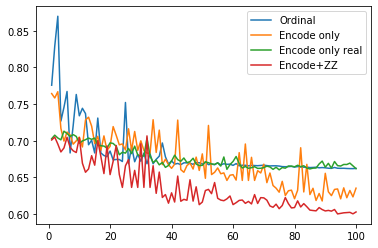

In [75]:
# Get some plot
# Training loss
x_plot = np.arange(1, 101)

plt.plot(x_plot, vqc_ordinal_log, label='Ordinal')
plt.plot(x_plot, vqc_encode_only_log, label='Encode only')
plt.plot(x_plot, vqc_encode_only_real_log, label='Encode only real')
plt.plot(x_plot, vqc_encode_zz_log, label='Encode+ZZ')
plt.legend()